# COPD data analysis

This is a general exploratory analysis of the COPD patient-spell data.

In [1]:
import itertools as it
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

from pandas.plotting import register_matplotlib_converters
from scipy import stats

%matplotlib inline

plt.style.use("seaborn-colorblind")
register_matplotlib_converters()
cutoff = 100

In [2]:
copd = pd.read_csv(
    "/Volumes/thesis-data/copd.csv",
    parse_dates=[
        "admission_date",
        "discharge_date",
        "first_pr_date",
        "last_pr_date",
        "first_sn_date",
        "last_sn_date",
    ],
)

# Patient-level analysis


In [3]:
copd.head()

,spell_id,n_spells,n_wards,gender,n_consultants,patient_id,admission_date,discharge_date,los,n_pr_attendances,...,neoplasms,nervous,perinatal,respiratory,skin,special_use,n_icds,intervention,pr,sn
0,M801616557,2,2,M,2,SB286342,2018-05-13 14:41:00,2018-05-16 15:54:00,3,1,...,0,0,0,2,0,0,12,pr,1,0
1,M126800878827,1,1,M,1,SB154003,2017-06-27 17:16:00,2017-06-28 11:33:00,1,0,...,0,0,0,1,0,0,4,none,0,0
2,M600182547,1,1,F,1,SB119474,2015-04-20 12:04:00,2015-04-20 16:06:00,0,0,...,0,0,0,1,0,0,2,none,0,0
3,M2572148,3,2,F,3,SB249566,2016-08-29 17:40:00,2016-08-31 20:01:00,2,0,...,0,0,0,1,0,0,4,none,0,0
4,M802361235,2,2,M,2,SB227617,2019-03-01 16:35:00,2019-03-06 17:00:00,5,0,...,0,1,0,1,0,0,7,none,0,0


In [4]:
copd[["spell_id", "patient_id", "period"]].nunique()

spell_id      10881
patient_id     5243
period           96
dtype: int64

In [5]:
copd["gender"].value_counts()

F    5990
M    4907
Name: gender, dtype: int64

In [6]:
copd["admission_date"].min(), copd["admission_date"].max()

(Timestamp('2011-02-01 15:00:00'), Timestamp('2019-03-29 21:03:00'))

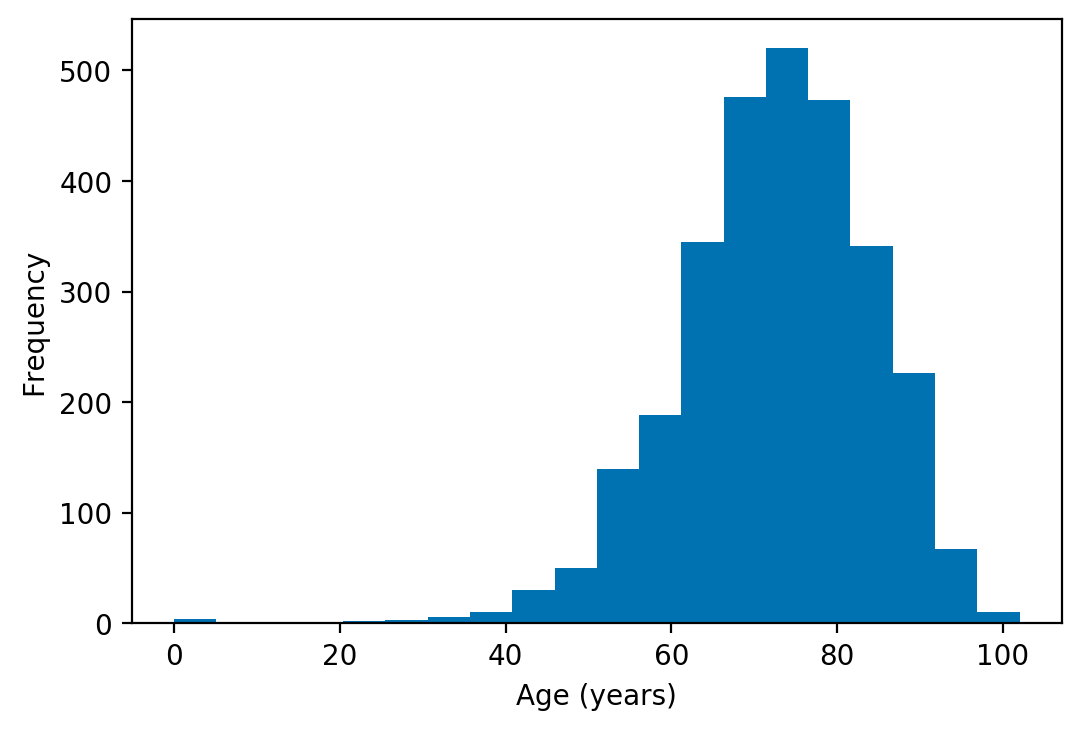

In [7]:
fig, ax = plt.subplots(dpi=200)

ages = copd.groupby("patient_id")["age"].median().dropna()
ax.hist(ages, bins=20)

ax.set_xlabel("Age (years)")
ax.set_ylabel("Frequency")

plt.savefig("../img/age.pdf", transparent=True)

Use the following function to reformat the `deprivation_decile` column of the dataset.

```python
def reformat_decile(decile_string):

    if not isinstance(decile_string, str):
        return decile_string
    
    direction, percentage = decile_string.split(" ")
    number = int(percentage.replace("%", ""))

    if direction.lower() == "highest":
        return 100 - number
    return number - 10

copd["deprivation_decile"] = copd["deprivation_decile"].apply(
    lambda decile_string: reformat_decile(decile_string)
)
```

Text(0, 0.5, 'Frequency')

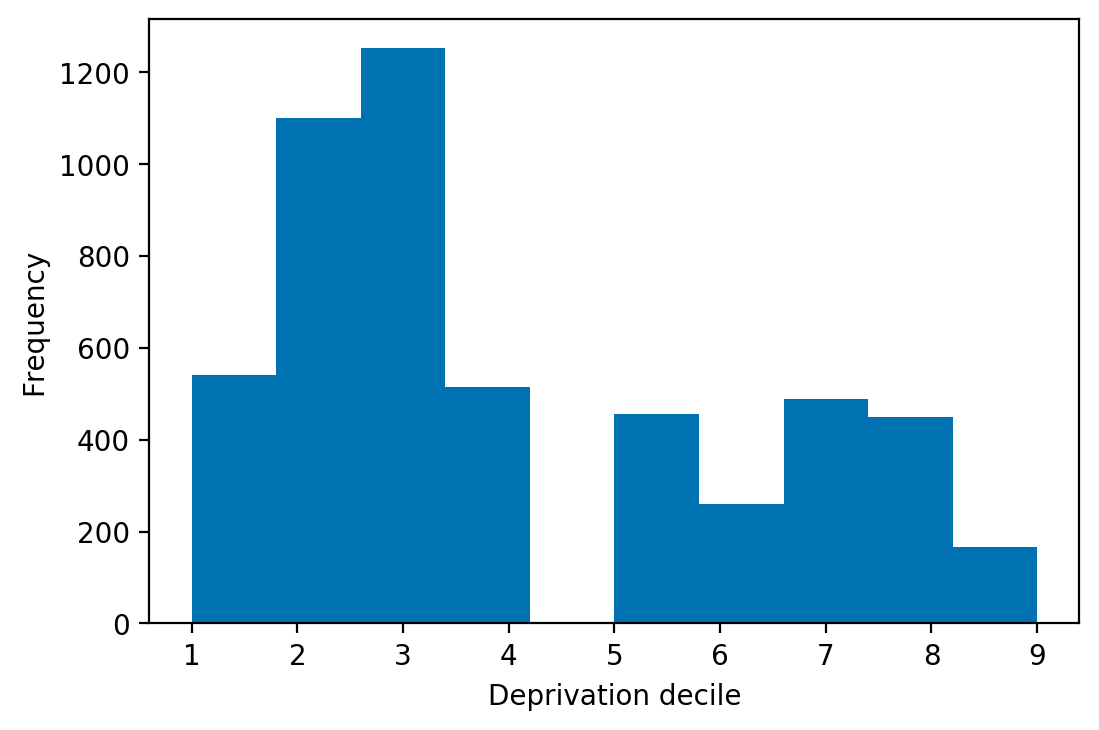

In [8]:
fig, ax = plt.subplots(dpi=200)

deprivation_deciles = copd.groupby("patient_id")["deprivation_decile"].median().dropna()

ax.hist(deprivation_deciles, bins=10)

ax.set_xlabel("Deprivation decile")
ax.set_ylabel("Frequency")

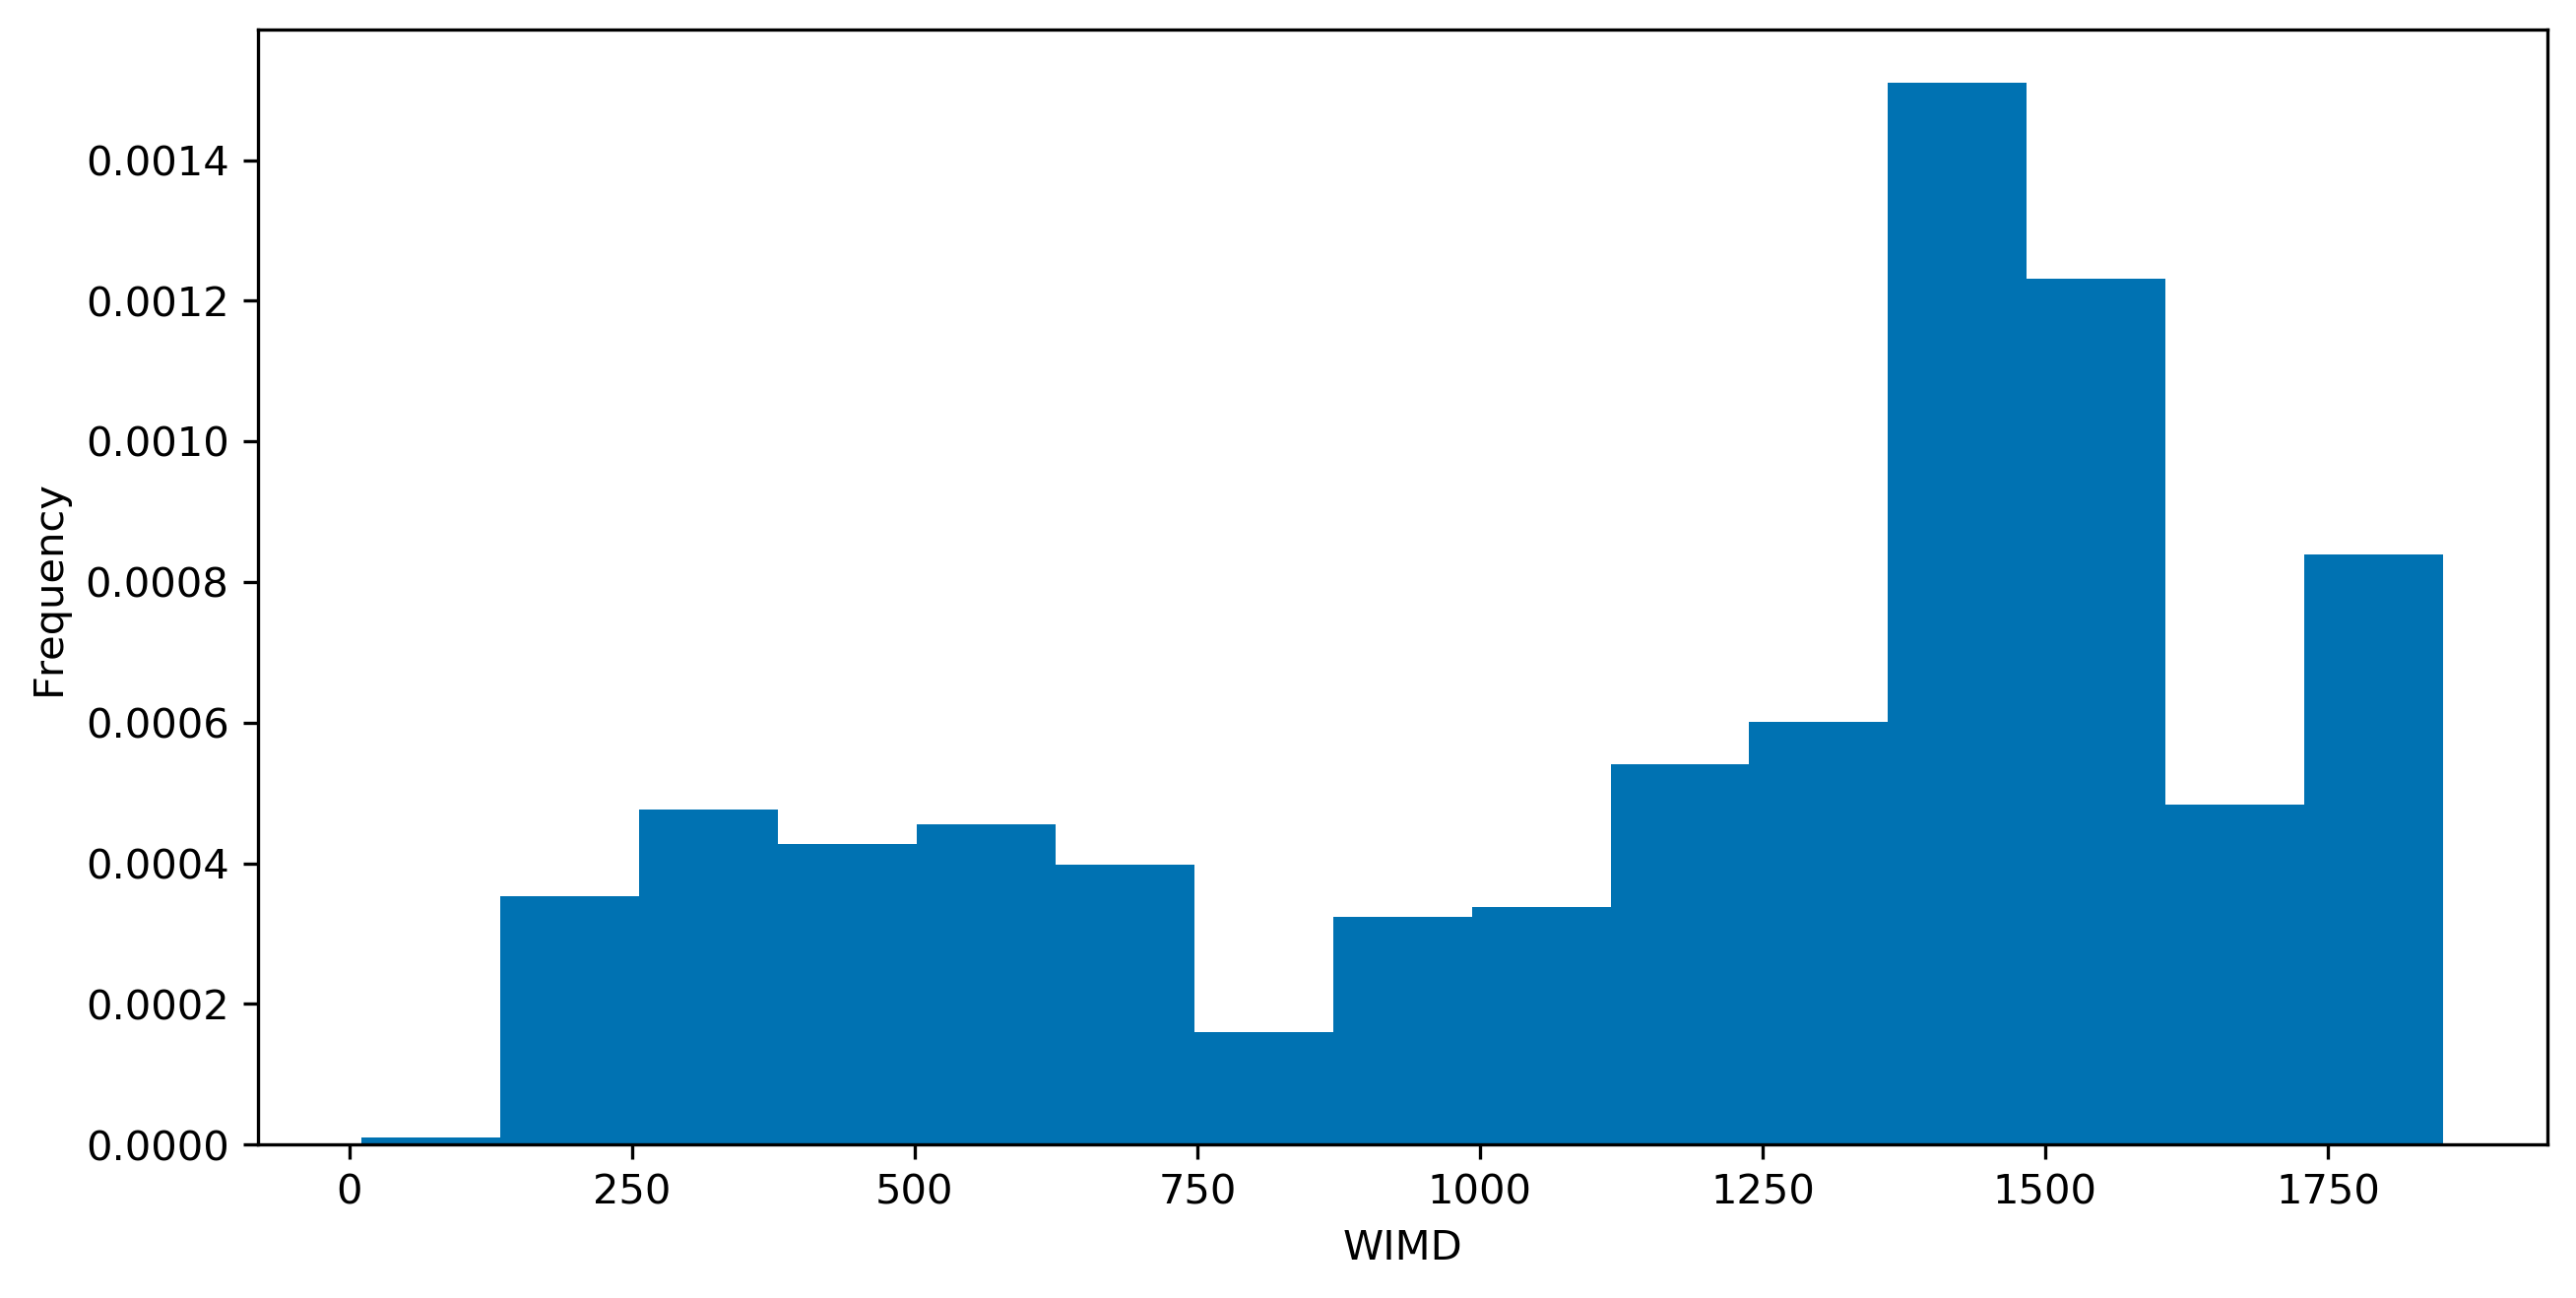

In [9]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

wimds = copd.groupby("patient_id")["wimd"].median().dropna()
ax.hist(wimds, bins=15, density=True)

ax.set_xlabel("WIMD")
ax.set_ylabel("Frequency")

plt.savefig("../img/wimd.pdf", transparent=True)

The following code gets the spell costs for the spells that are known in `main.csv`.

```python
spell_costs = (
    main[main["SPELL_ID"].isin(copd["spell_id"].values)]\
                         .groupby(["SPELL_ID"])["NetCost"]\
                         .sum()\
                         .to_dict()
)

copd["spell_cost"] = copd["spell_id"].map(lambda spell_id: spell_costs.get(spell_id))
```

Text(0, 0.5, 'Count')

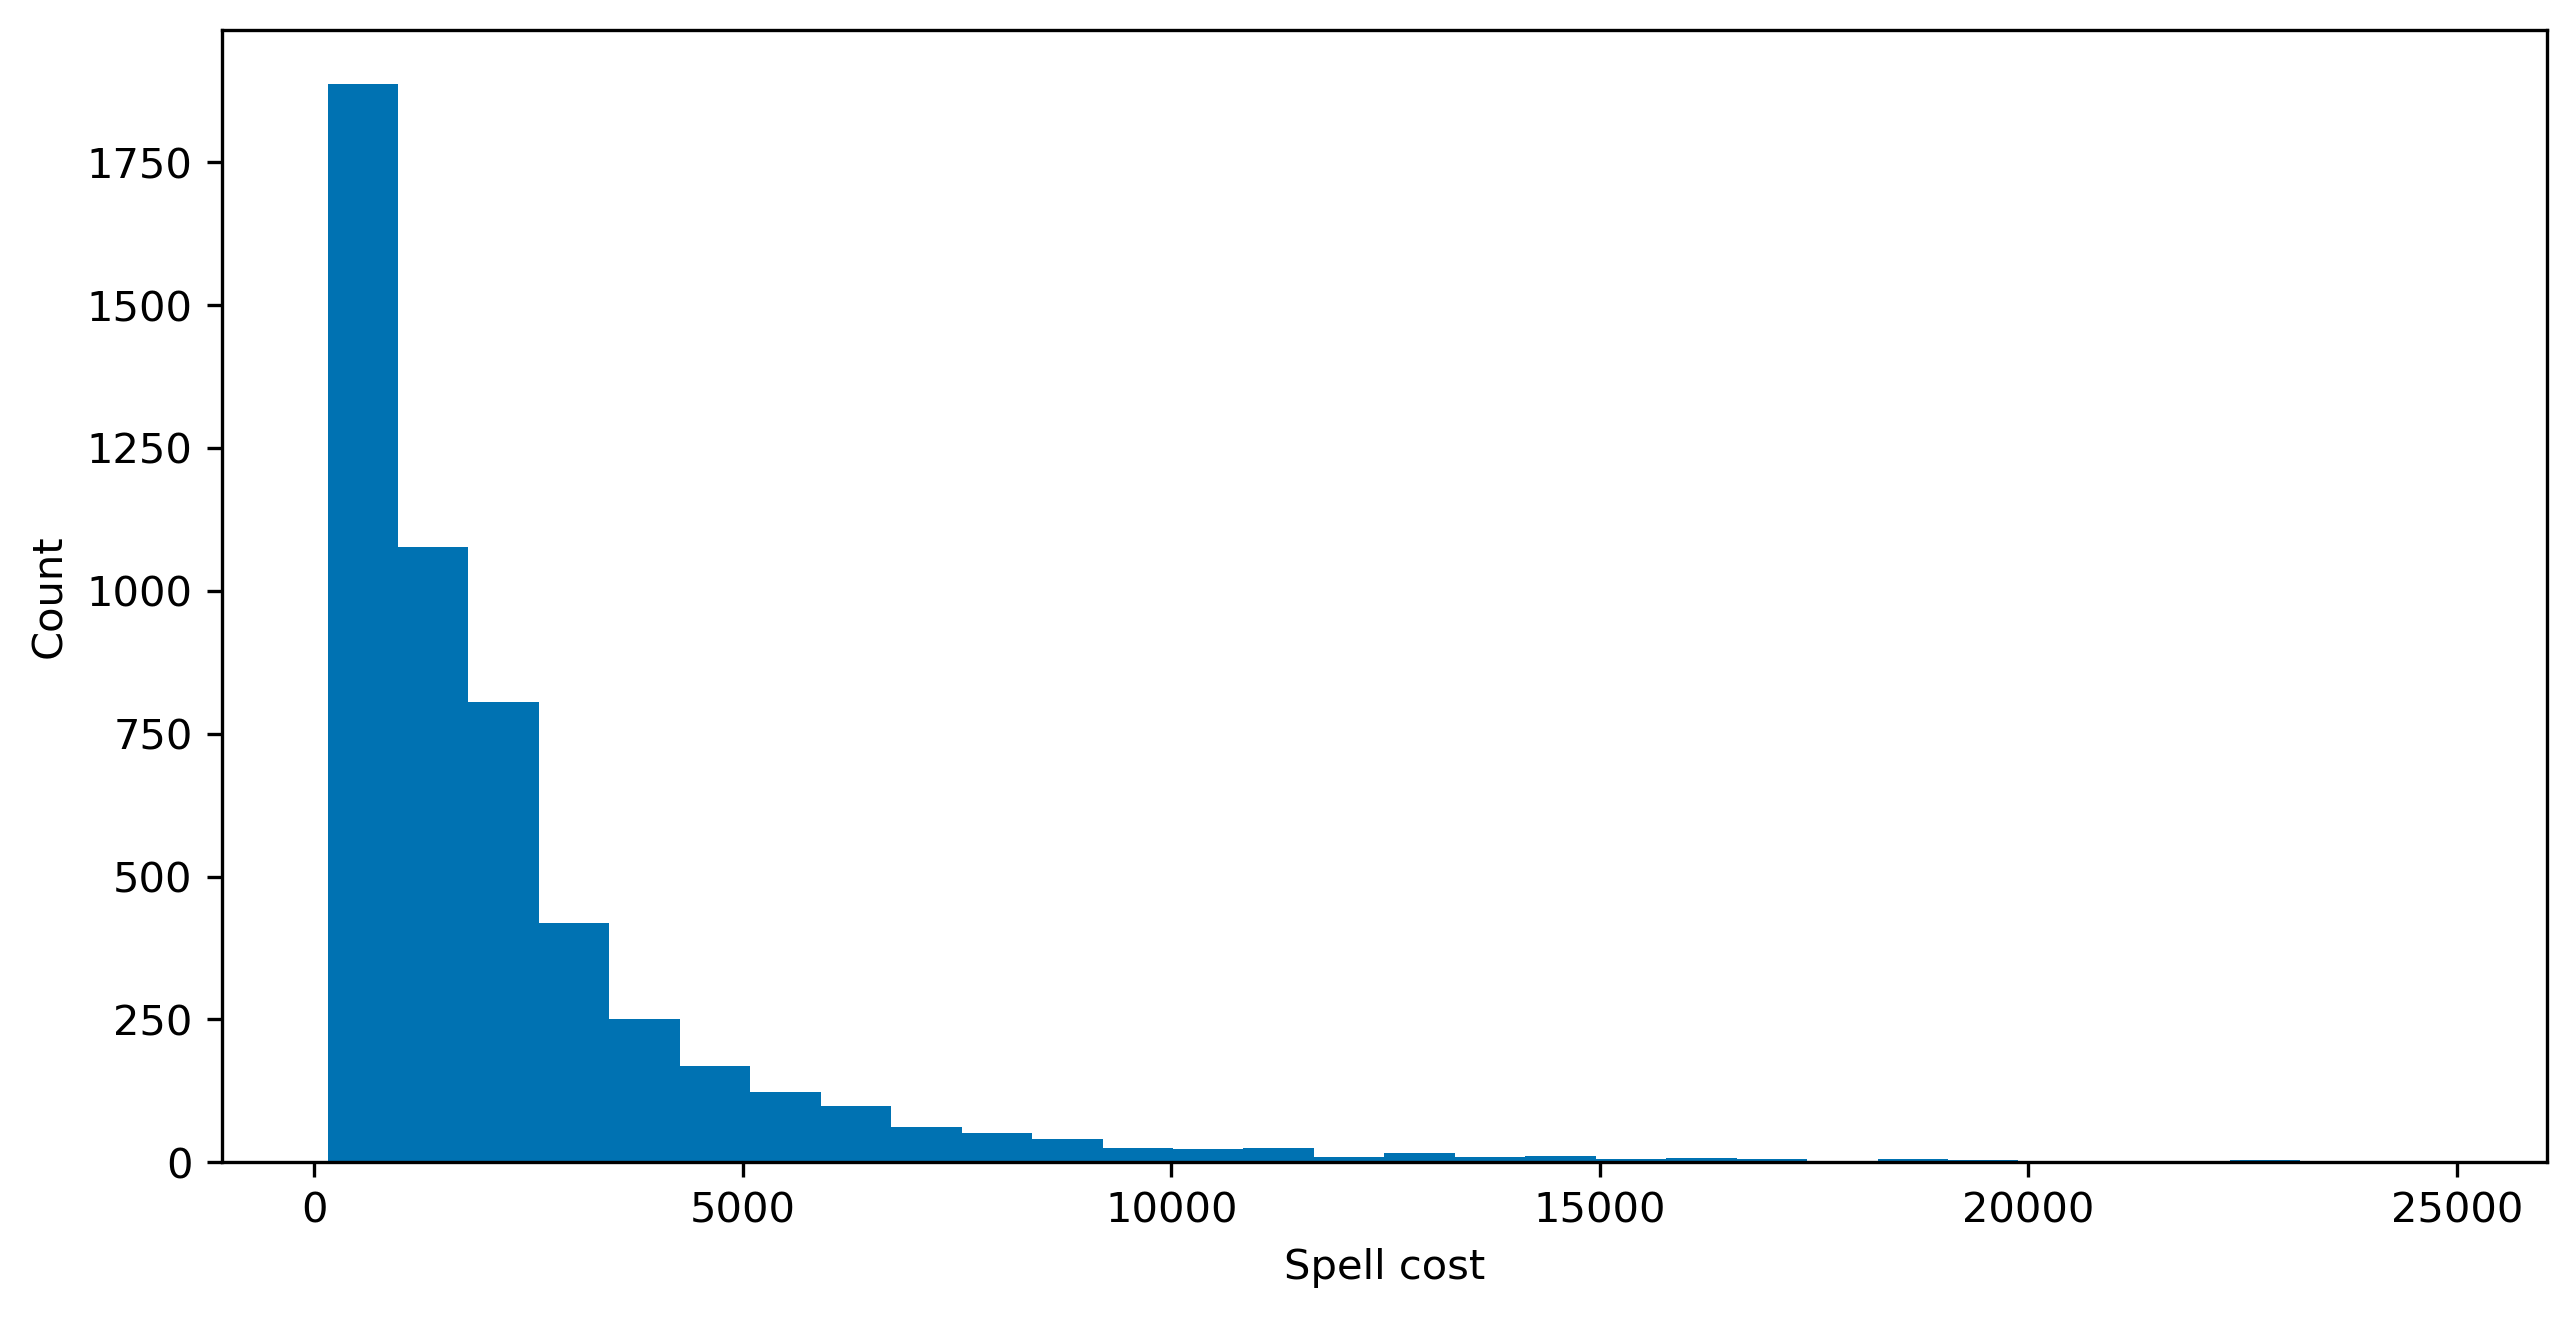

In [10]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

costs = copd["spell_cost"].dropna().values

ax.hist(costs, bins=30)

ax.set_xlabel("Spell cost")
ax.set_ylabel("Count")


# Looking at length of stay


In [11]:
copd["true_los"] = (
    copd["discharge_date"] - copd["admission_date"]
).dt.total_seconds() / (24 * 60 * 60)
copd[["los", "true_los"]].describe().iloc[1:, :]


,los,true_los
mean,7.823346,7.855679
std,16.084912,16.059508
min,0.000000,-0.020833
25%,1.000000,1.486111
50%,4.000000,4.190278
75%,9.000000,8.928472
max,995.000000,995.056250


Text(0, 0.5, 'Length of stay (days)')

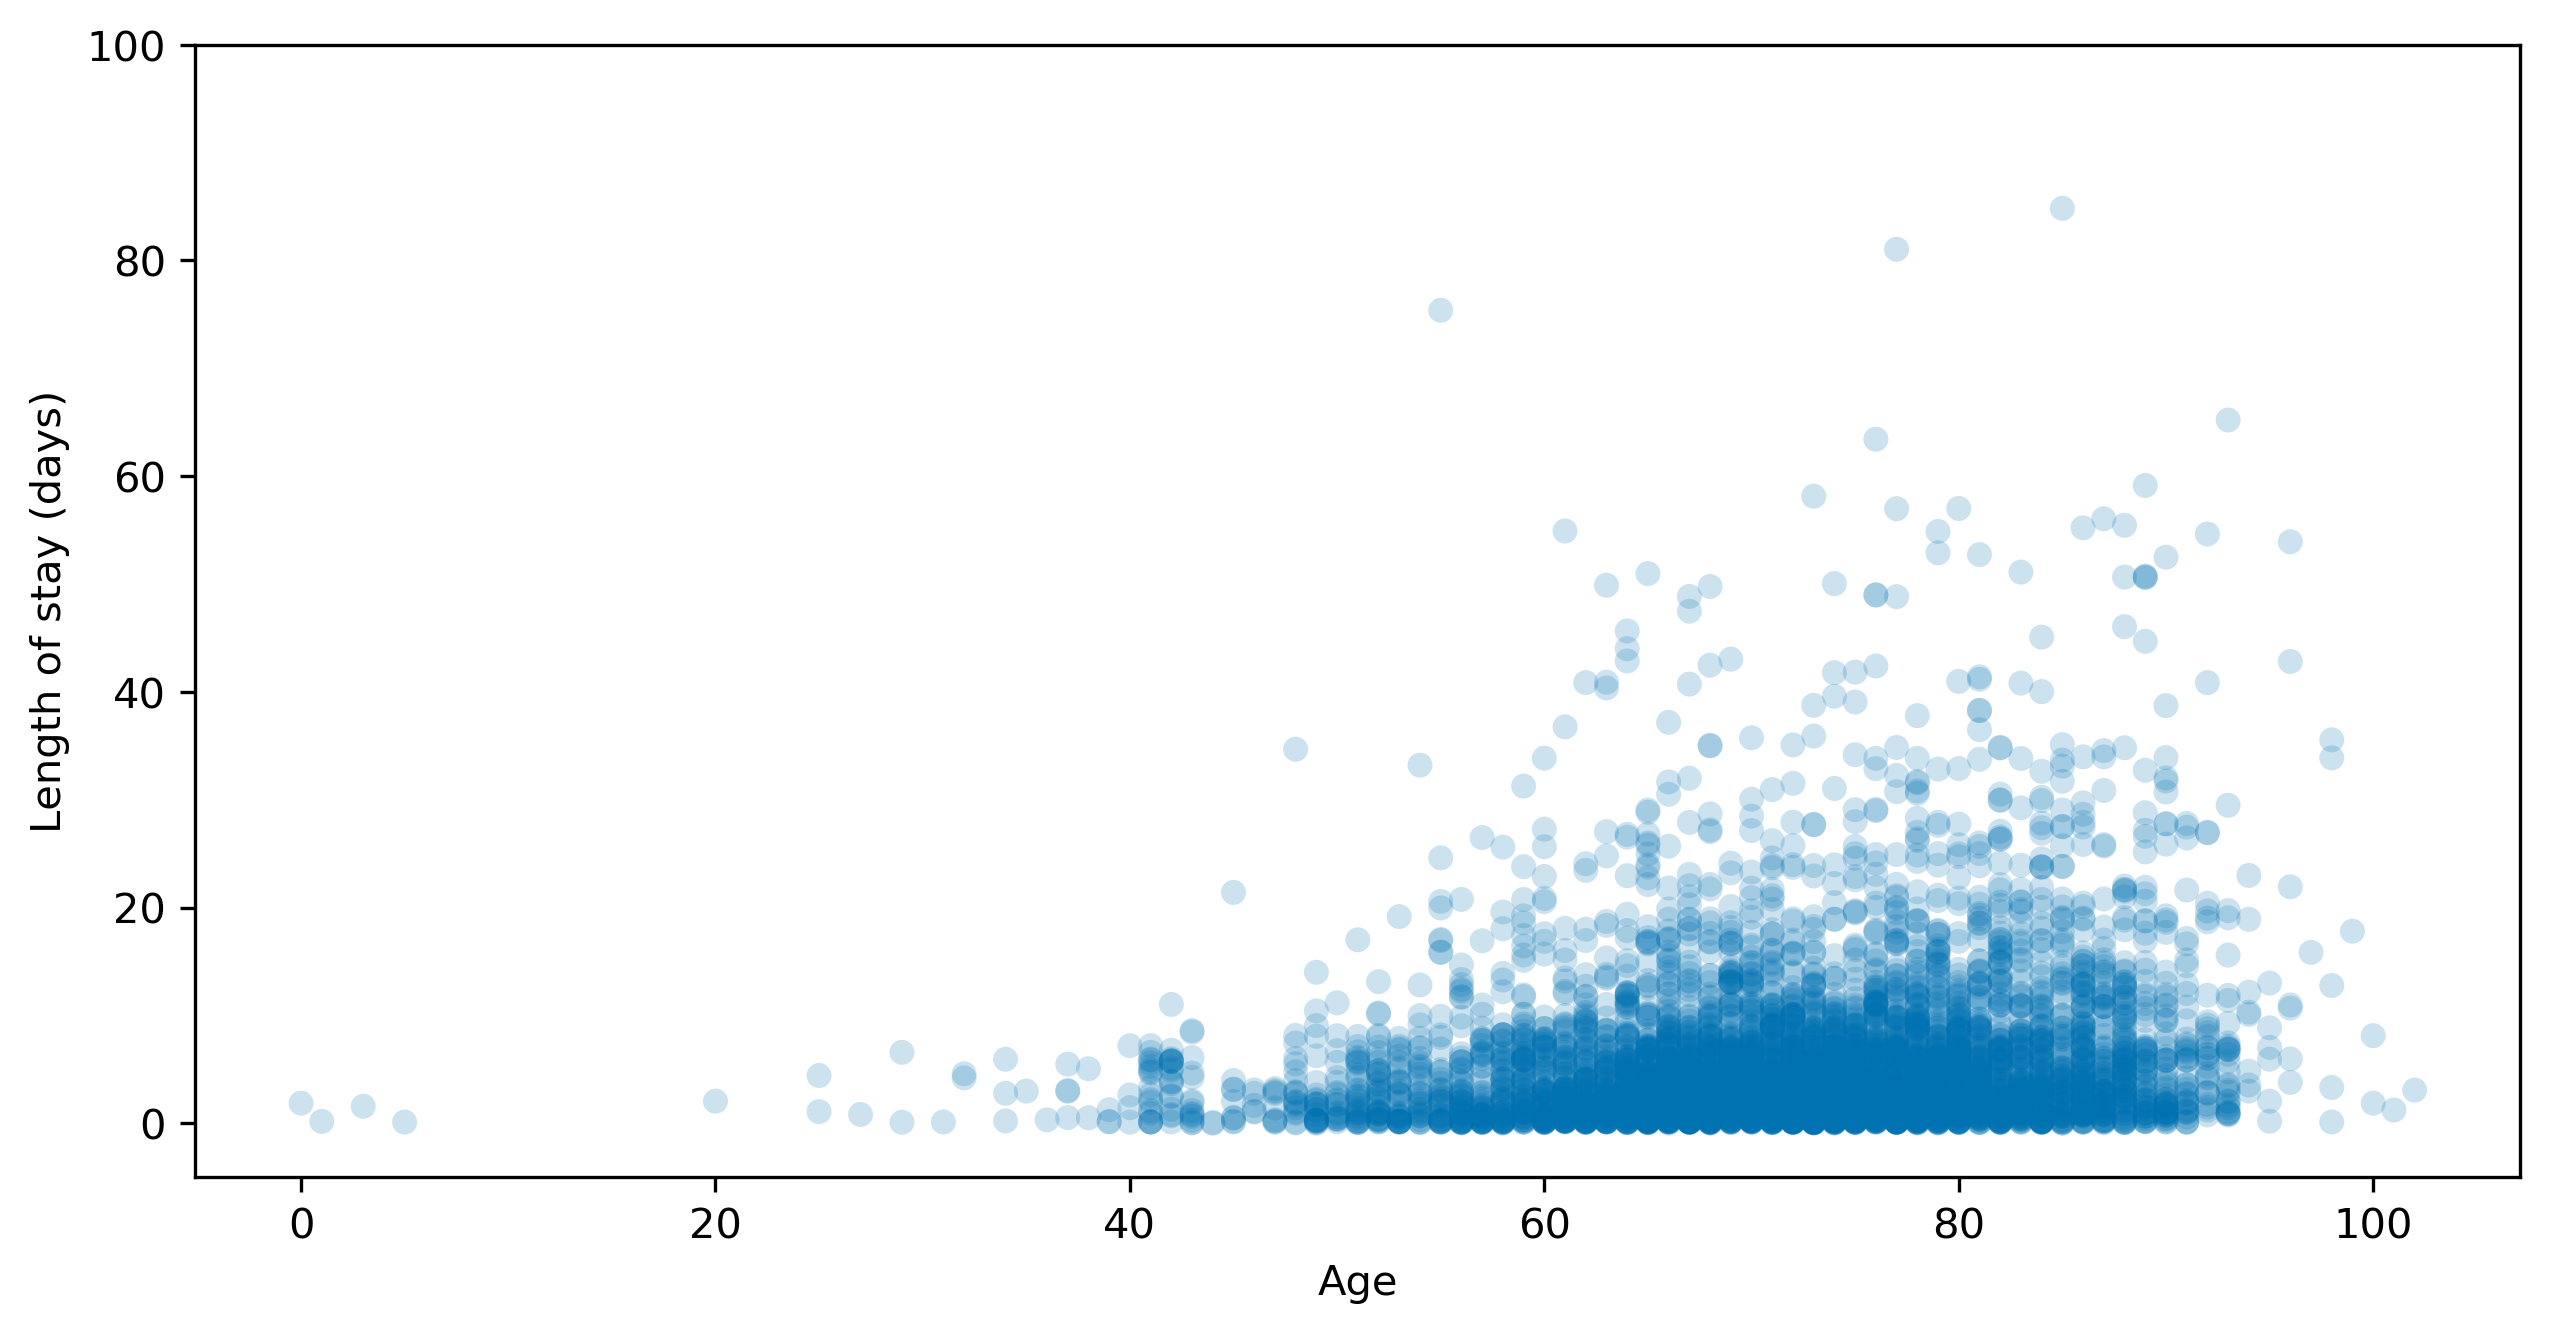

In [12]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

ax.scatter(copd["age"], copd["true_los"], alpha=0.2, edgecolor="None")

ax.set_ylim(-5, 100)
ax.set_xlabel("Age")
ax.set_ylabel("Length of stay (days)")


[(-5, 55),
 Text(0, 0.5, 'Length of stay (days)'),
 [Text(0, 0, 'F'), Text(0, 0, 'M')],
 Text(0.5, 0, 'Gender')]

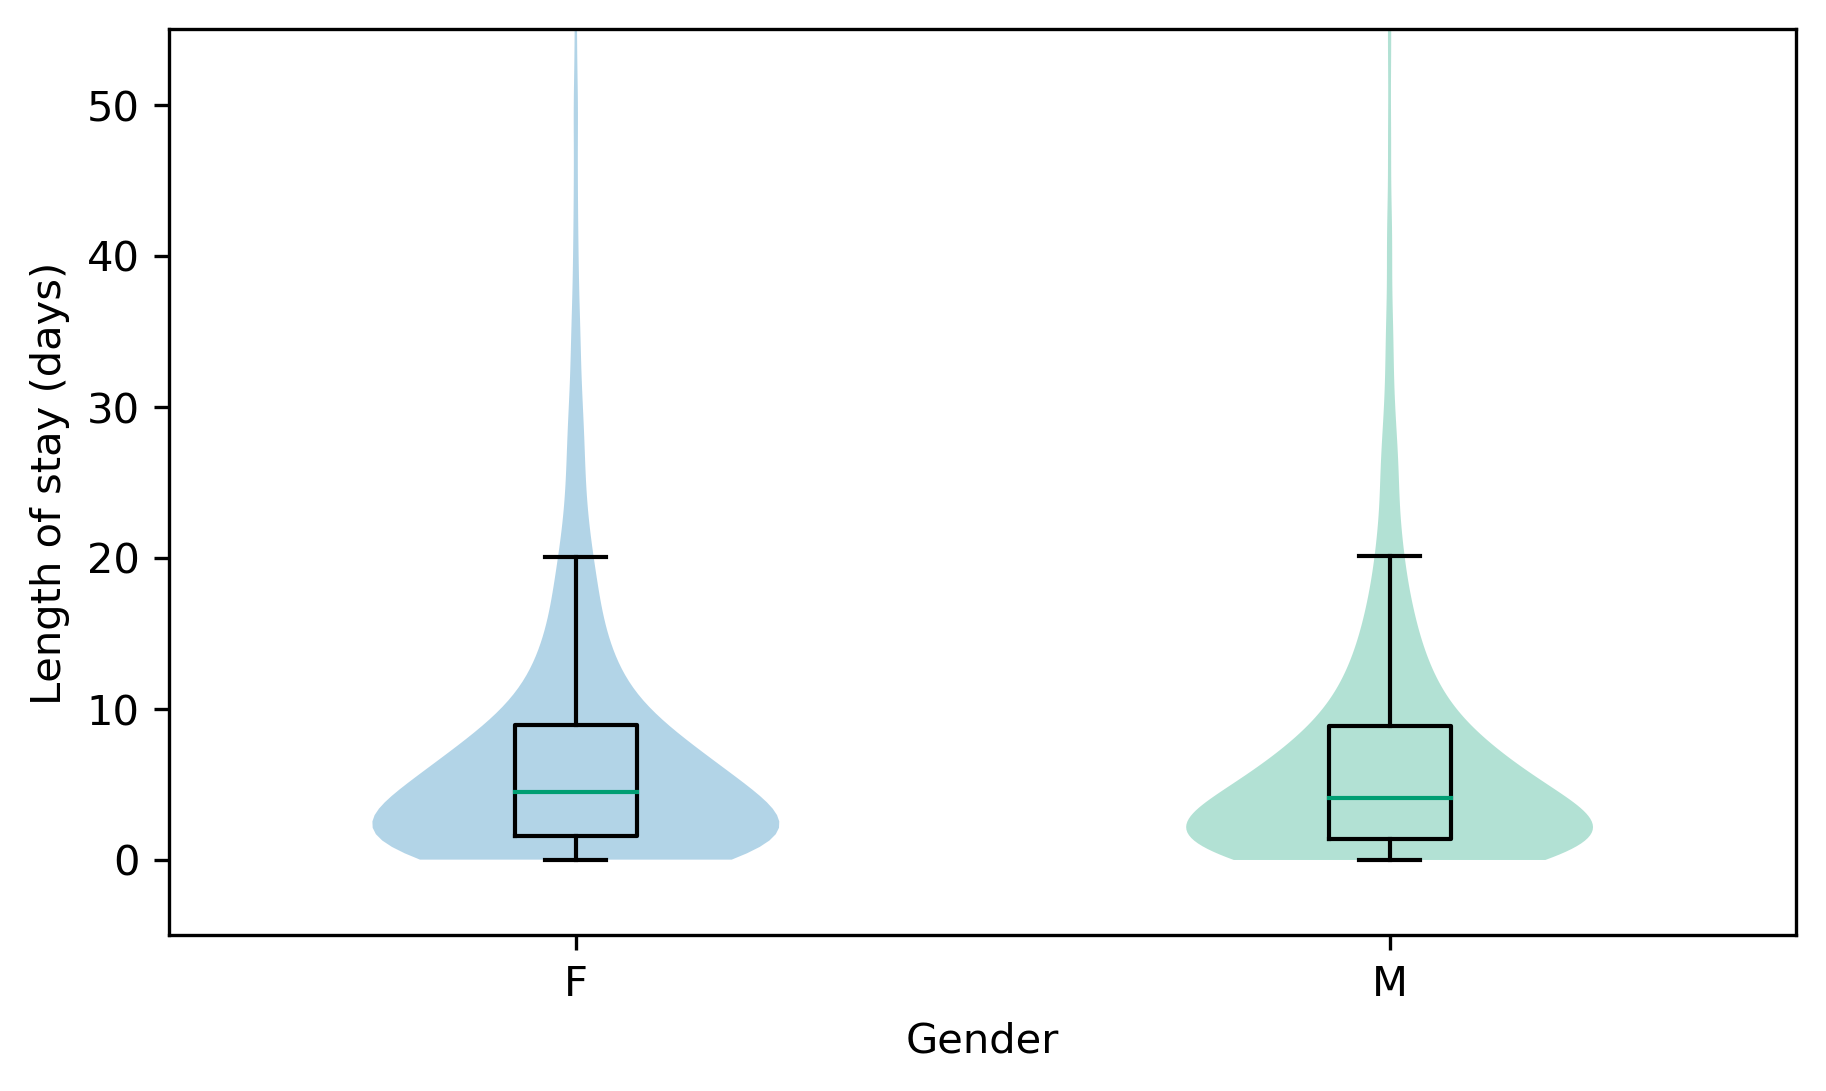

In [13]:
fig, ax = plt.subplots(figsize=(7, 4), dpi=300)

xticklabels = []
for pos, (gender, los_values) in enumerate(copd.groupby("gender")["true_los"]):

    trimmed_values = los_values[los_values < np.percentile(los_values, cutoff)]
    ax.violinplot(trimmed_values, (pos,), showextrema=False, points=1000)
    ax.boxplot(trimmed_values, positions=(pos,), sym="")
    xticklabels.append(gender)

ax.set(
    xlabel="Gender",
    ylabel="Length of stay (days)",
    xticklabels=xticklabels,
    ylim=(-5, 55),
)

Text(0, 0.5, 'Length of stay (days)')

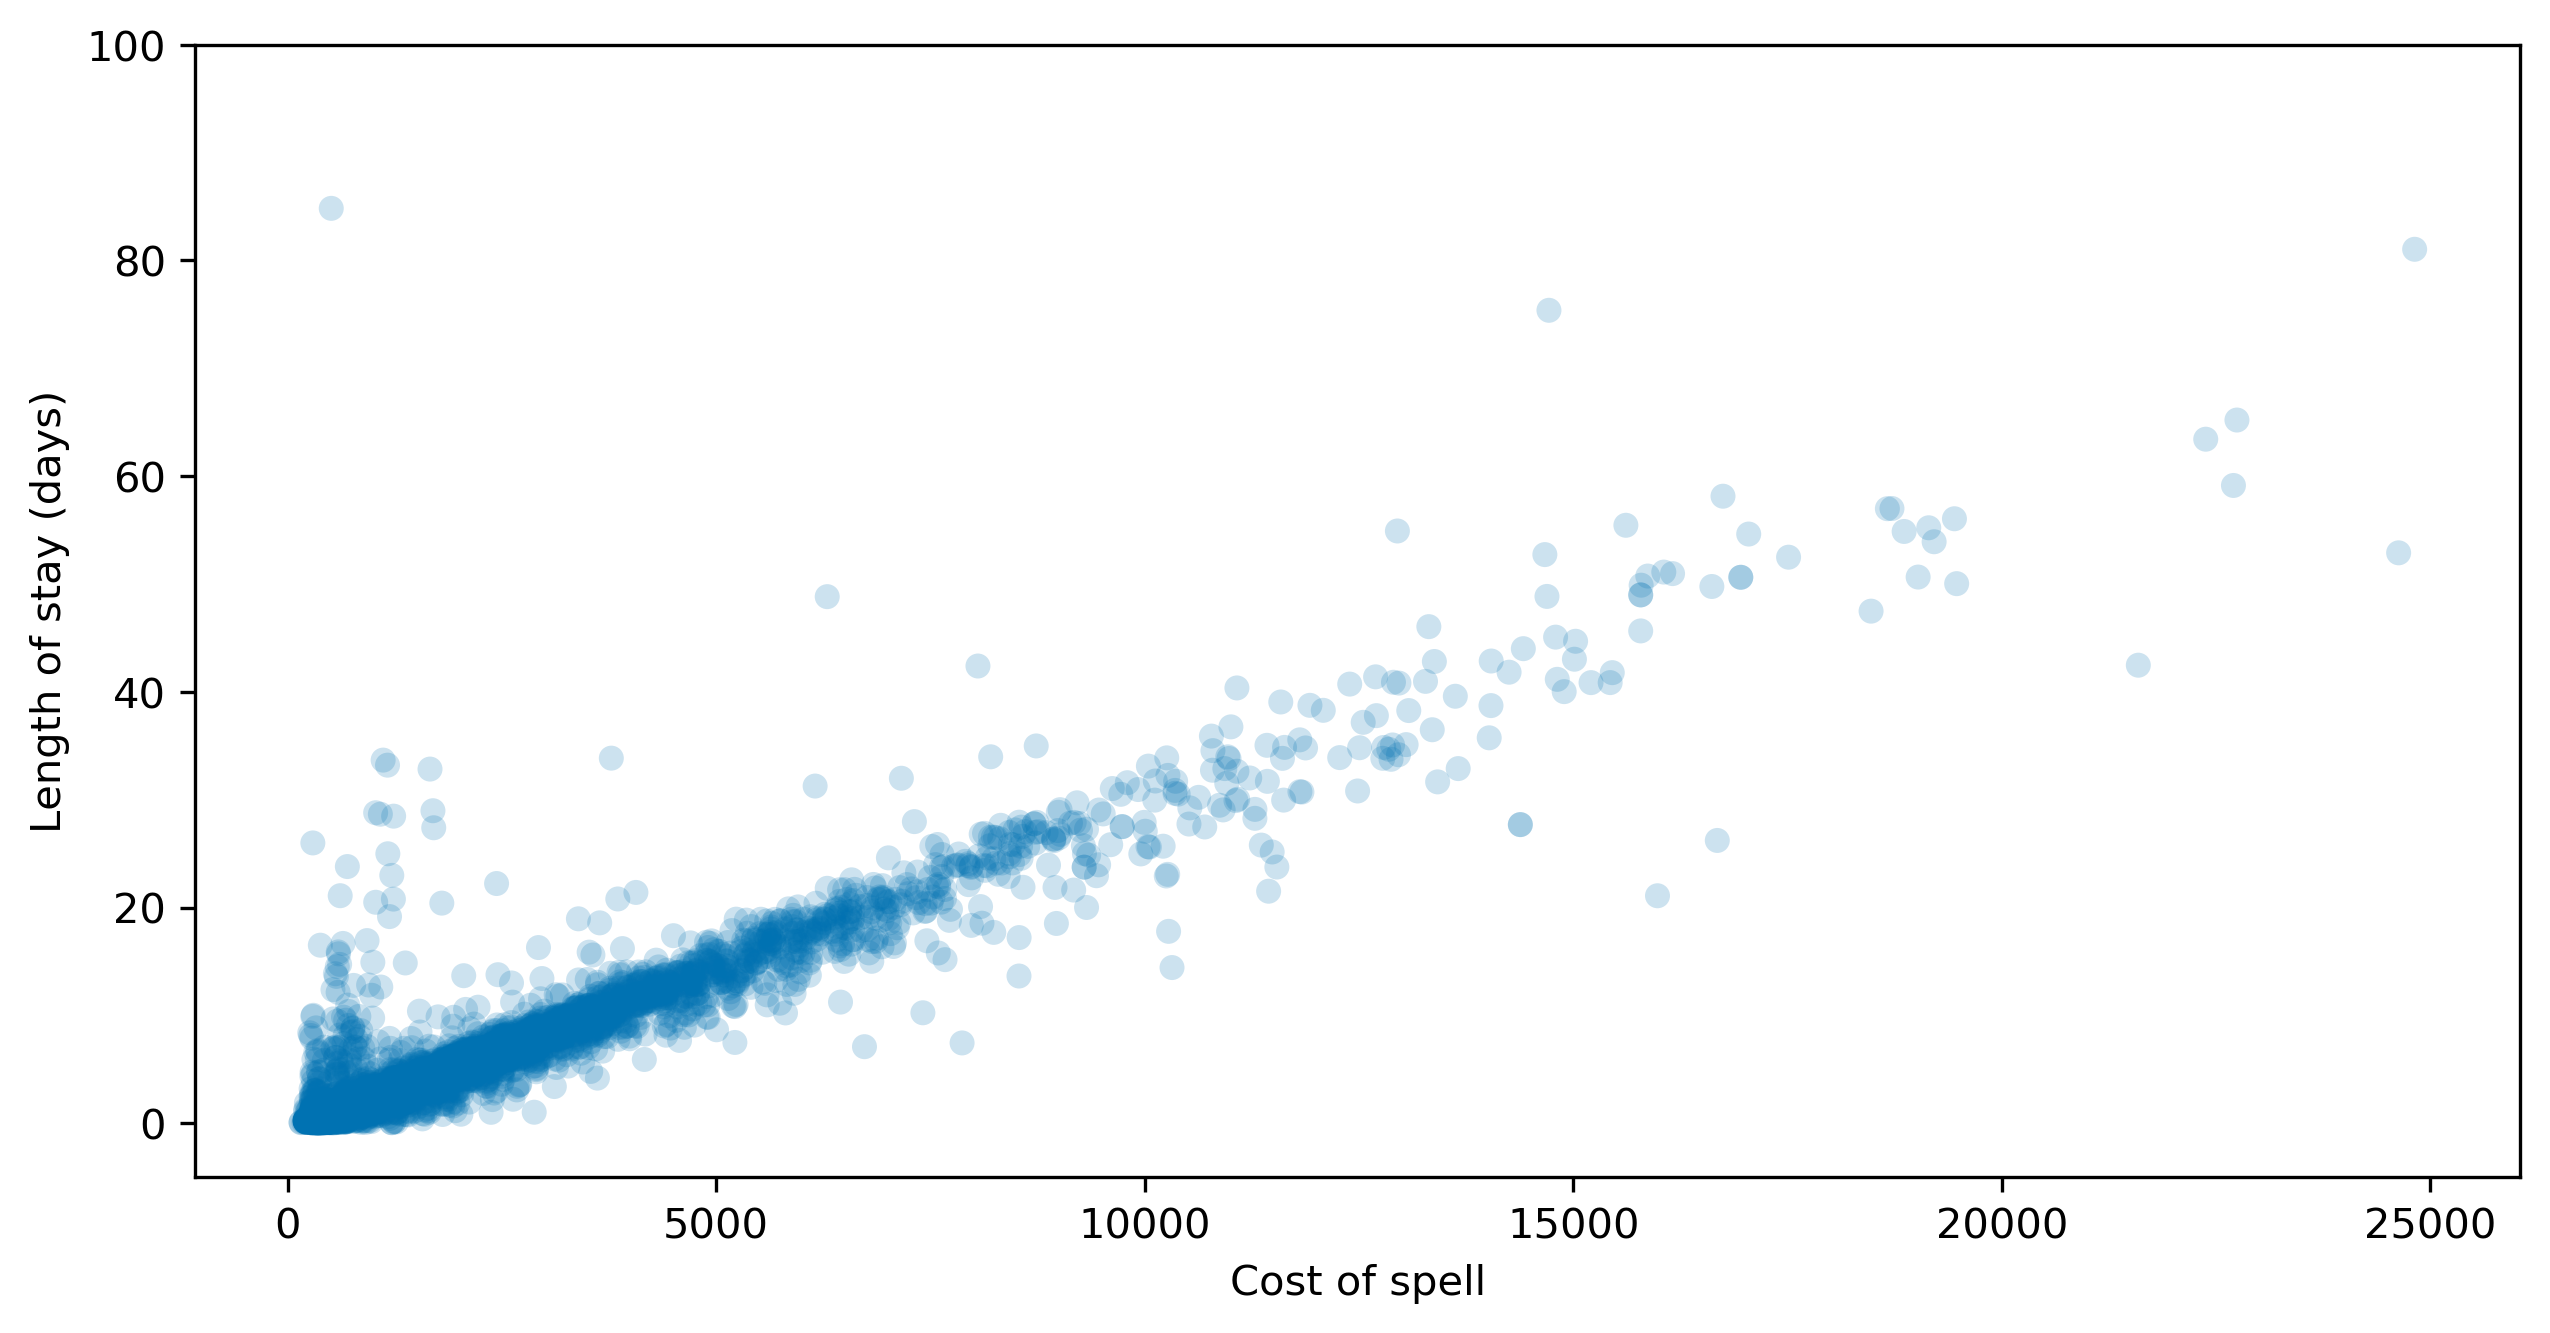

In [14]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

ax.scatter(copd["spell_cost"], copd["true_los"], alpha=0.2, edgecolor="None")

ax.set_ylim(-5, 100)
ax.set_xlabel("Cost of spell")
ax.set_ylabel("Length of stay (days)")


Text(0, 0.5, 'Length of stay (days)')

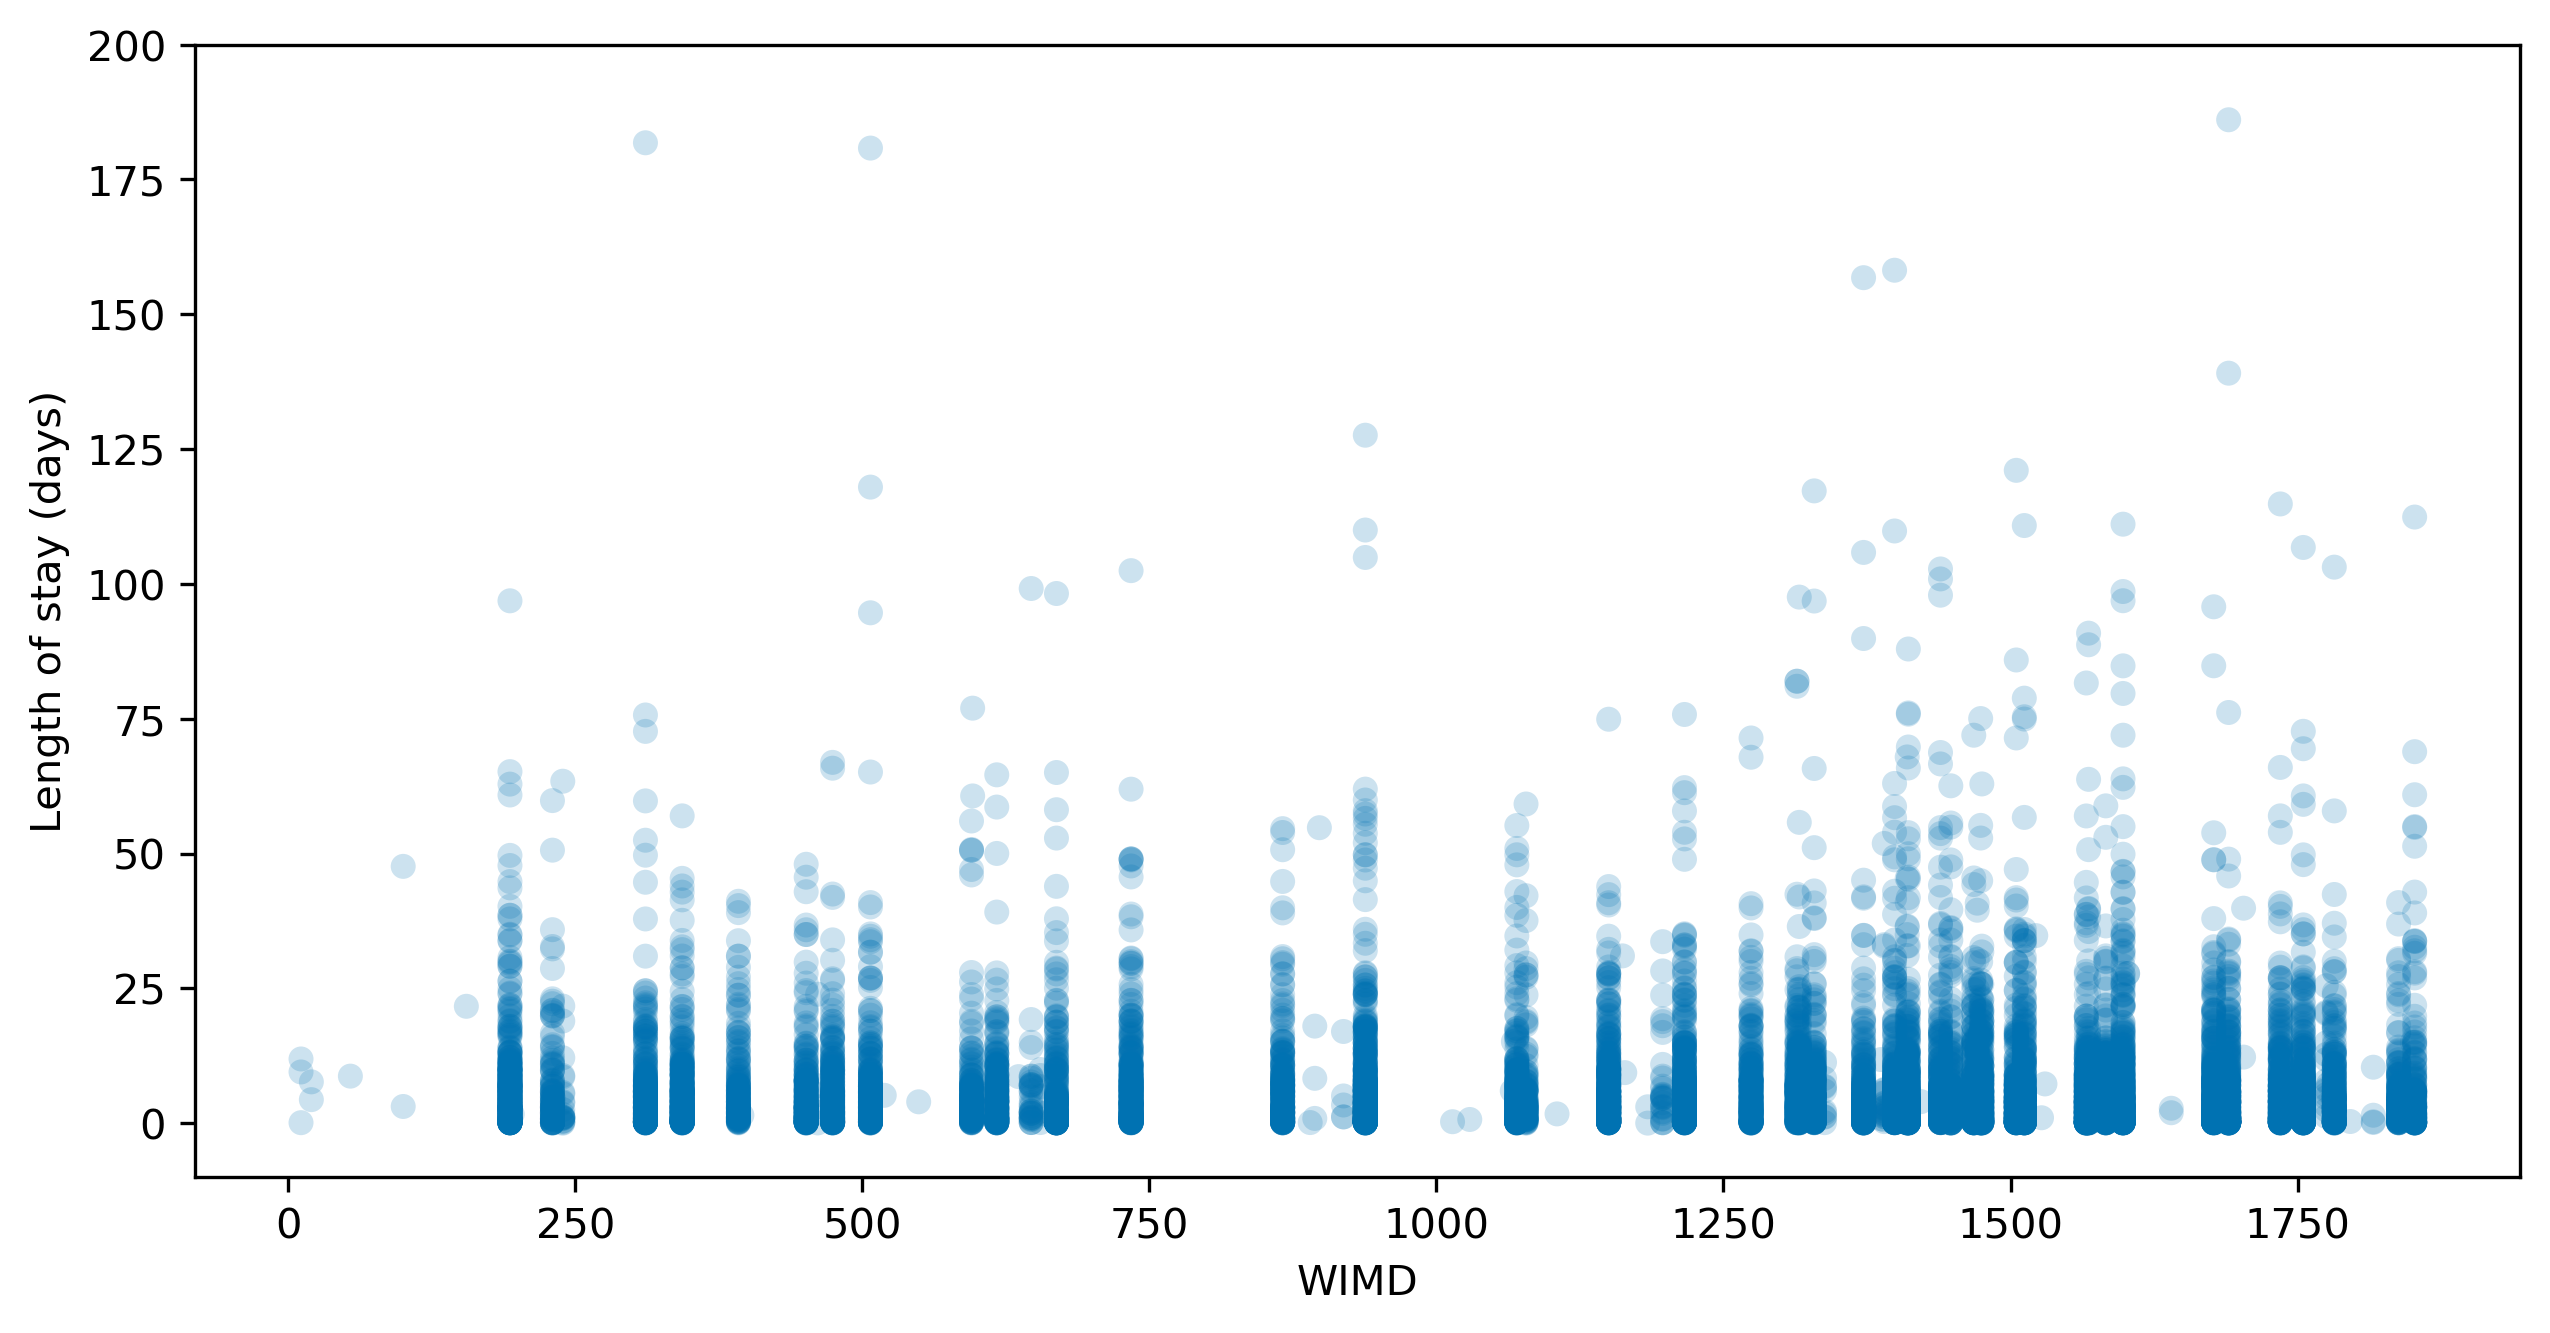

In [15]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

ax.scatter(copd["wimd"], copd["true_los"], alpha=0.2, edgecolor="None")

ax.set_ylim(-10, 200)

ax.set_xlabel("WIMD")
ax.set_ylabel("Length of stay (days)")


# Summarising ICD codes

It is likely that diagnosis will be helpful in predicting length of stay or intervention later on.

So, let us summarise the ICD codes by their main categories (via: the [WHO website](https://icd.who.int/browse10/2016/en)). To begin, each spell's ICD codes must be collated and stacked:

In [16]:
copd_icds = (
    pd.DataFrame(
        copd["icd_codes"]
        .str.split("|")
        .apply(lambda codes: [code.strip() for code in codes])
        .tolist(),
        index=copd["spell_id"],
    )
    .stack()
    .reset_index()
    .drop("level_1", axis=1)
)

copd_icds.columns = ["spell_id", "icd_code"]
copd_icds.head(15)


,spell_id,icd_code
0,M801616557,J448
1,M801616557,Z954
2,M801616557,R798
3,M801616557,N189
4,M801616557,D696
5,M801616557,Z950
6,M801616557,D649
7,M801616557,I489
8,M801616557,I272
9,M801616557,J988


In [17]:
f"There are {copd_icds['icd_code'].nunique()} unique ICDs present."


'There are 1926 unique ICDs present.'

These are the code ranges taken from the website. Each ICD is encoded as a string of length 3 (the stem) plus some sub-category. To make things easier and to avoid any discrepancies in the encoding, we'll only deal with the stem.

In [18]:
icd_ranges = {
    "infectious": ("A00", "B99"),
    "neoplasms": ("C00", "D48"),
    "blood": ("D50", "D89"),
    "endocrine": ("E00", "E90"),
    "mental": ("F00", "F99"),
    "nervous": ("G00", "G99"),
    "eye": ("H00", "H59"),
    "ear": ("H60", "H95"),
    "circulatory": ("I00", "I99"),
    "respiratory": ("J00", "J99"),
    "digestive": ("K00", "K93"),
    "skin": ("L00", "L99"),
    "muscoloskeletal": ("M00", "M99"),
    "genitourinary": ("N00", "N99"),
    "pregnancy": ("O00", "O99"),
    "perinatal": ("P00", "P99"),
    "congenital": ("Q00", "Q99"),
    "abnormal_findings": ("R00", "R99"),
    "injury": ("S00", "T98"),
    "external_causes": ("V01", "Y98"),
    "contact_factors": ("Z00", "Z99"),
    "special_use": ("U00", "U89"),
}


In [19]:
f"There are {len(icd_ranges)} ICD categories."


'There are 22 ICD categories.'

With the stems extracted, the next step is to effectively replace the stem column by its category.

In [20]:
copd_icds["icd_code_stem"] = (
    copd_icds["icd_code"].copy().str.slice(start=0, stop=3, step=1)
)

copd_icds["category"] = copd_icds["icd_code_stem"].copy()
for category, limits in icd_ranges.items():
    copd_icds["category"] = np.where(
        copd_icds["icd_code_stem"].between(*limits), category, copd_icds["category"]
    )

copd_icds.head()


,spell_id,icd_code,icd_code_stem,category
0,M801616557,J448,J44,respiratory
1,M801616557,Z954,Z95,contact_factors
2,M801616557,R798,R79,abnormal_findings
3,M801616557,N189,N18,genitourinary
4,M801616557,D696,D69,blood


In [21]:
observed_icds = copd_icds["category"].unique()

f"There are {len(observed_icds)} unique ICD categories present."

if len(observed_icds) < len(icd_ranges):
    print(f"Missing categories: {set(icd_ranges.keys()).difference(observed_icds)}")


Missing categories: {'pregnancy'}


Now so we can merge this data with the original `copd` dataframe, we must group by `spell_id`, collate the categories and count the occurrences of each category. This is done using `pd.get_dummies()`.

In [22]:
spell_icds_list = copd_icds.groupby("spell_id")["category"].apply(list).reset_index()
spell_icds_list.head()


,spell_id,category
0,M126601423287,"[respiratory, infectious, contact_factors]"
1,M126601423852,"[respiratory, contact_factors, digestive, resp..."
2,M126601424305,"[respiratory, circulatory, mental, abnormal_fi..."
3,M126601424325,"[respiratory, mental, digestive, genitourinary..."
4,M126601424579,"[respiratory, digestive, respiratory, respirat..."


In [23]:
stacked_spell_icds = spell_icds_list["category"].apply(pd.Series).stack()

spell_icds = pd.get_dummies(stacked_spell_icds).sum(level=0)
spell_icds["n_icds"] = spell_icds.sum(axis=1)
spell_icds = spell_icds.join(spell_icds_list["spell_id"], how="outer")

spell_icds.head()


,abnormal_findings,blood,circulatory,congenital,contact_factors,digestive,ear,endocrine,external_causes,eye,...,mental,muscoloskeletal,neoplasms,nervous,perinatal,respiratory,skin,special_use,n_icds,spell_id
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3,M126601423287
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,2,0,0,4,M126601423852
2,1,0,2,0,0,0,0,0,0,0,...,1,2,0,0,0,1,0,0,7,M126601424305
3,0,0,0,0,1,1,0,1,0,0,...,1,0,0,0,0,3,0,0,8,M126601424325
4,0,0,1,0,0,2,0,0,0,0,...,0,1,0,0,0,3,0,0,7,M126601424579


In [24]:
if not set(spell_icds.columns).issubset(copd.columns):
    copd = copd.merge(spell_icds, how="inner", on="spell_id")


# LOS by category

In [25]:
los_by_category = {}
for category in copd_icds["category"].unique():
    los_by_category[category] = copd[copd[category] > 0]["true_los"].values

los_by_category_items = sorted(
    los_by_category.items(), key=lambda cat_values: -np.median(cat_values[1])
)


perinatal data has shape: (0,)


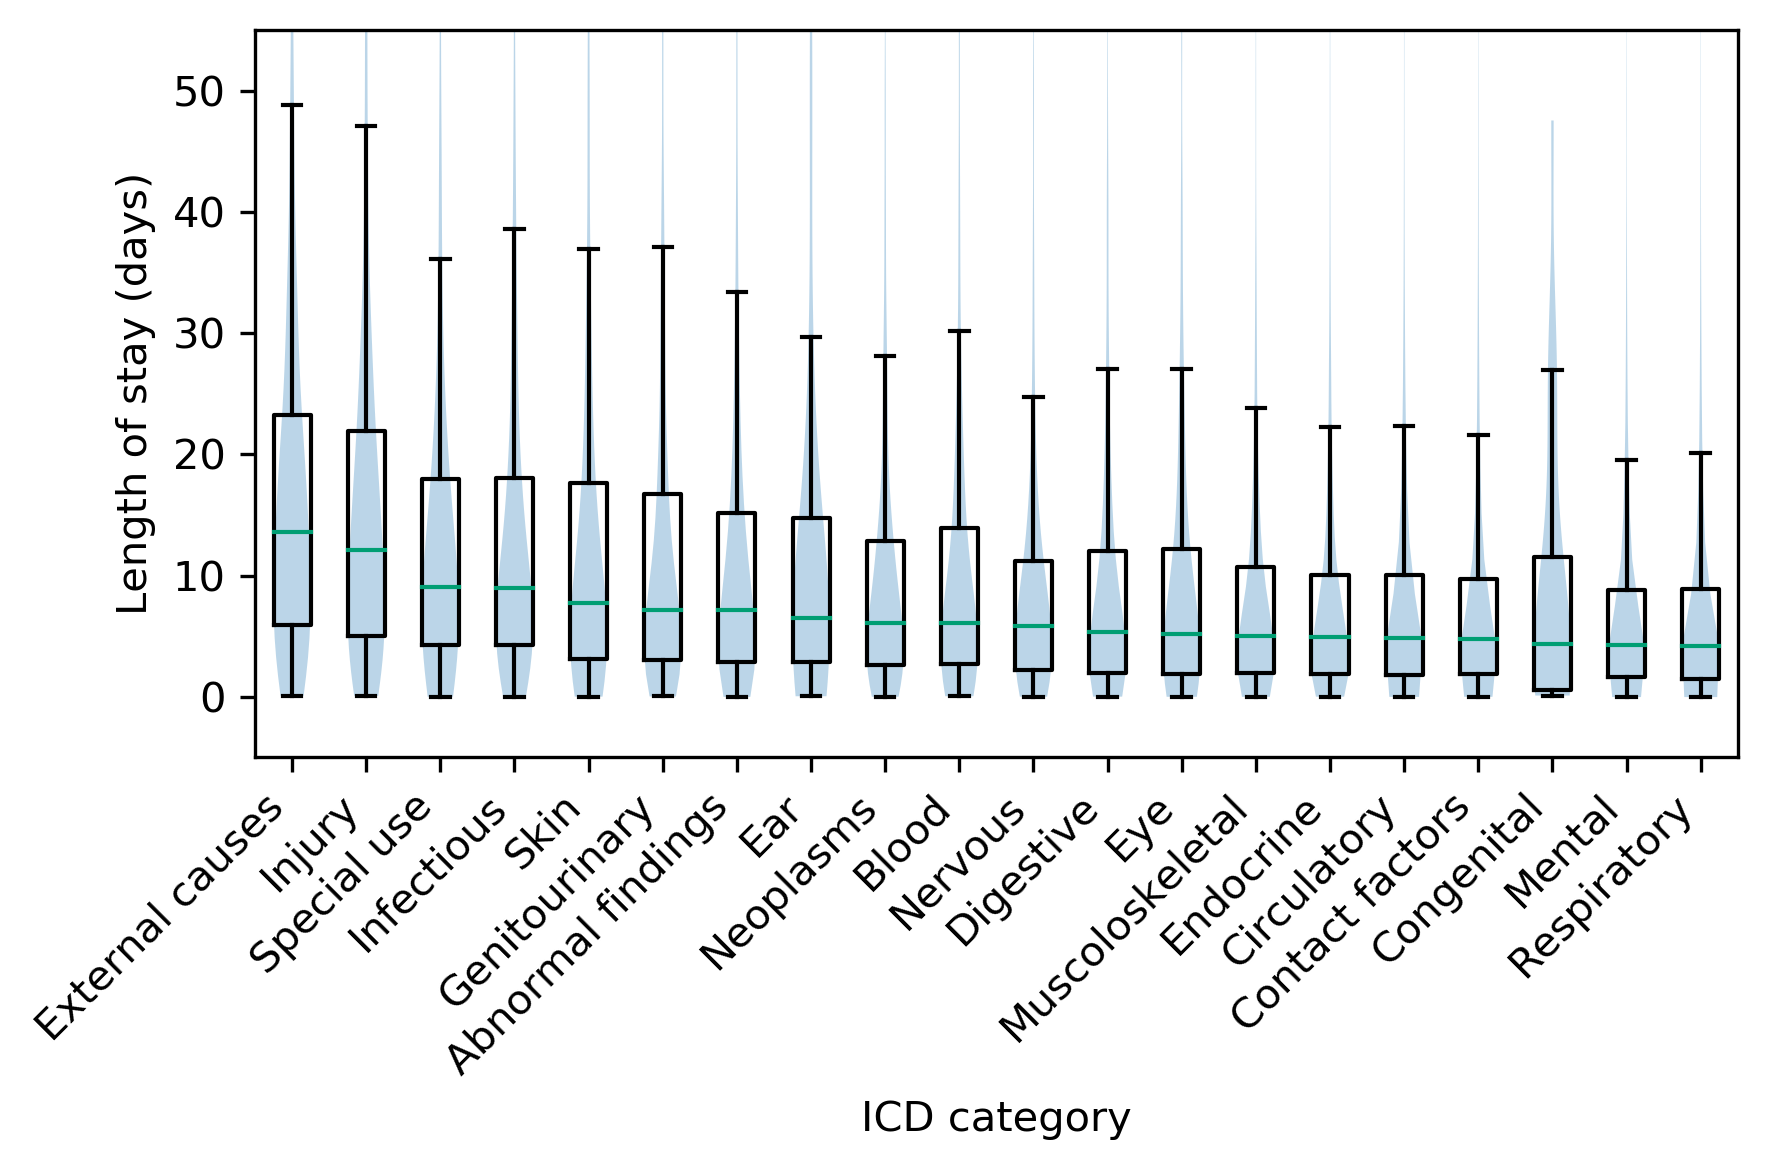

In [26]:
fig, ax = plt.subplots(dpi=300)

xticklabels = []
for pos, (category, los_values) in enumerate(los_by_category_items):
    data = los_values[los_values < np.percentile(los_values, cutoff)]

    try:
        parts = ax.violinplot(data, (pos,), showextrema=False)
        ax.boxplot(data, positions=(pos,), widths=0.5, sym="")
        xticklabels.append(" ".join(category.split("_")).capitalize())

        for body in parts["bodies"]:
            body.set_facecolor("tab:blue")

    except ValueError:
        print(category, "data has shape:", data.shape)

ax.set(
    xlabel="ICD category",
    ylabel="Length of stay (days)",
    xticklabels=xticklabels,
    ylim=(-5, 55),
)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")

plt.tight_layout()

# Costs by category

In [27]:
cost_by_category = {}
for category in copd_icds["category"].unique():
    values = copd[copd[category] > 0]["spell_cost"].dropna().values
    if any(values):
        cost_by_category[category] = values

cost_by_category_items = sorted(
    cost_by_category.items(), key=lambda cat_values: -np.median(cat_values[1])
)

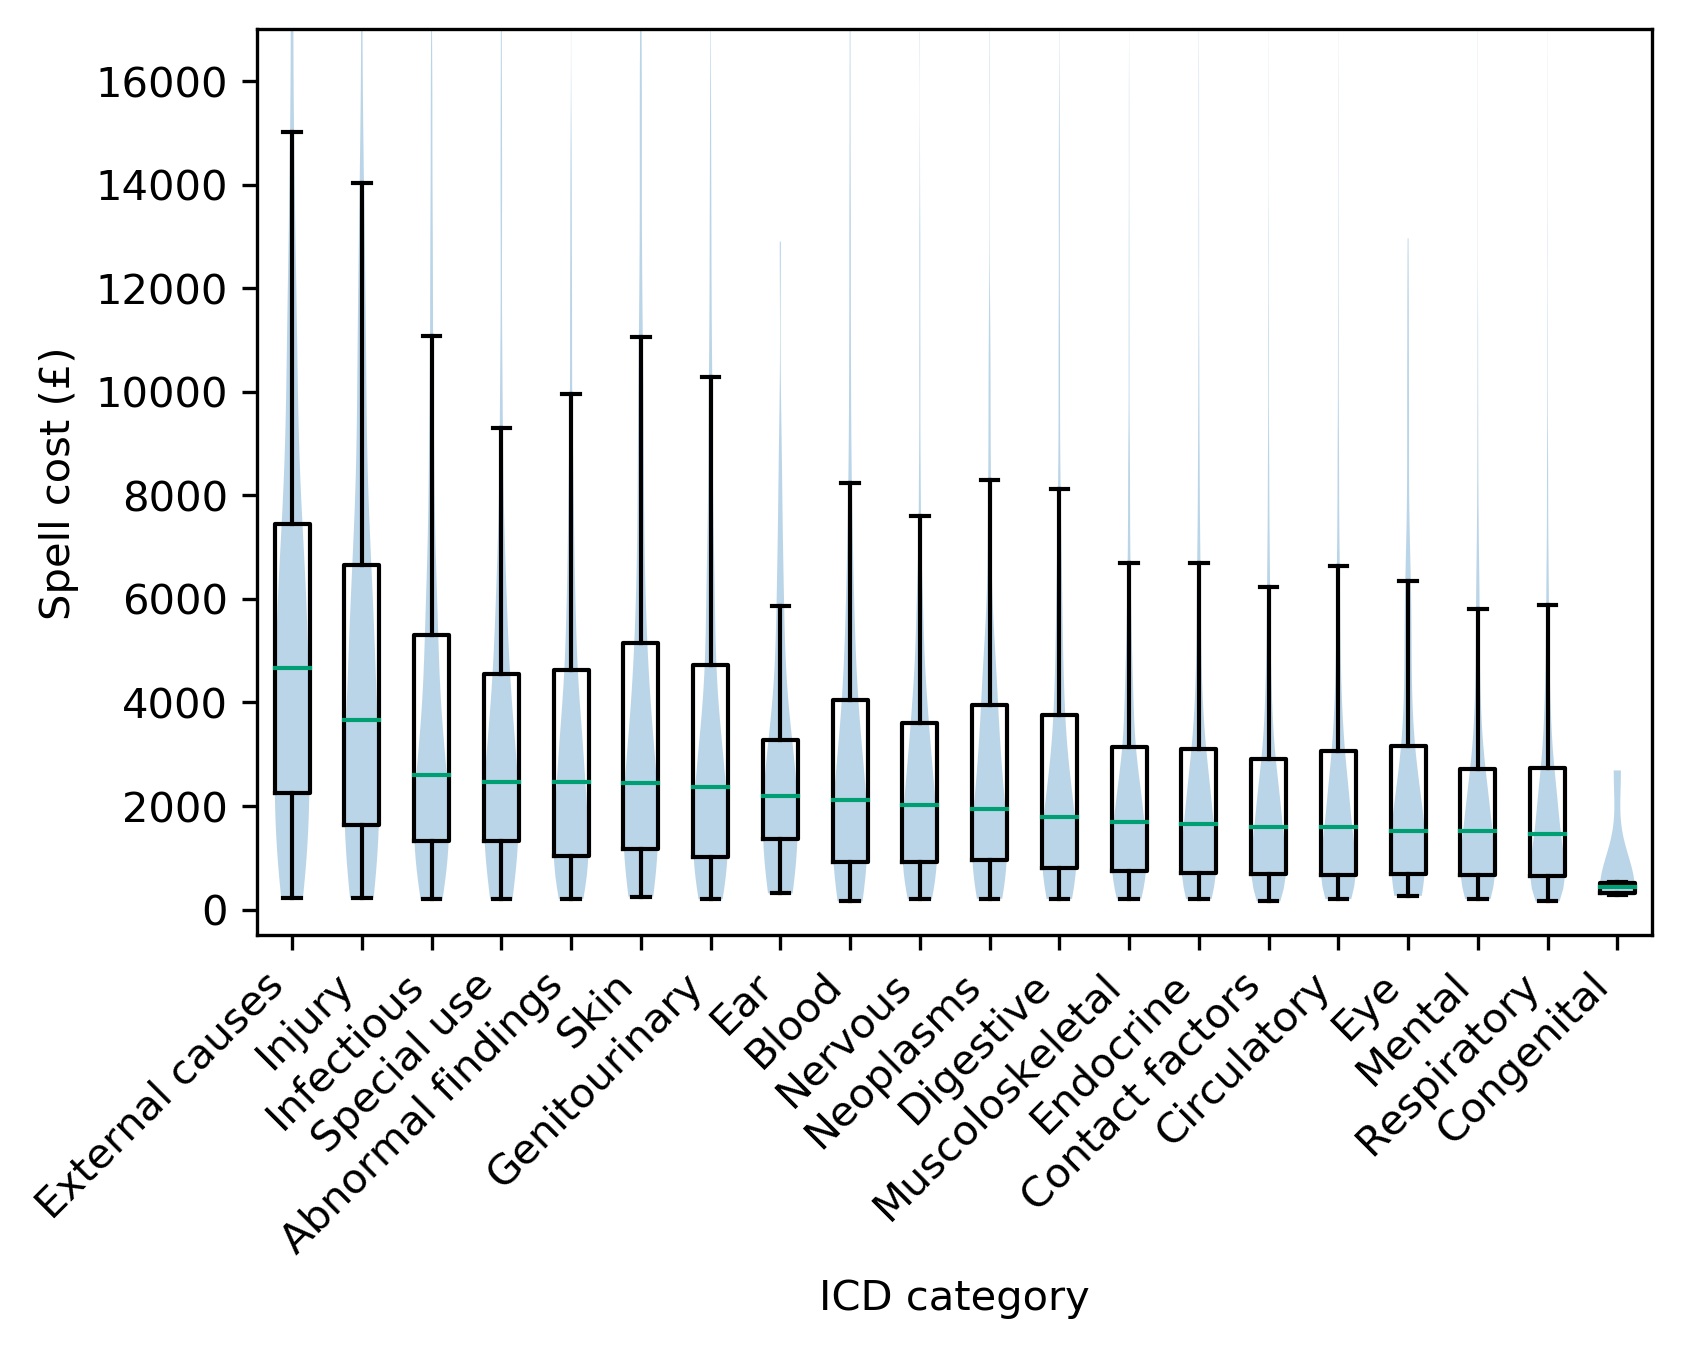

In [28]:
fig, ax = plt.subplots(dpi=300)

xticklabels = []
for pos, (category, costs) in enumerate(cost_by_category_items):
    data = costs[costs < np.percentile(costs, cutoff)]

    try:
        parts = ax.violinplot(data, (pos,), showextrema=False)
        ax.boxplot(data, positions=(pos,), widths=0.5, sym="")
        xticklabels.append(" ".join(category.split("_")).capitalize())

        for body in parts["bodies"]:
            body.set_facecolor("tab:blue")

    except ValueError:
        print(category, "data has shape:", data.shape)

ax.set(
    xlabel="ICD category",
    ylabel="Spell cost (£)",
    xticklabels=xticklabels,
    ylim=(-500, 17000),
)

for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")

# Measuring intervention effects


In [29]:
def summarise_intervention(statuses):

    pr_status, sn_status = statuses

    if pr_status == 0 and sn_status == 0:
        return "none"
    if pr_status and sn_status:
        return "both"
    if pr_status:
        return "pr"
    if sn_status:
        return "sn"

    return np.nan


In [30]:
copd["intervention"] = copd[["pr_status", "sn_status"]].apply(
    lambda statuses: summarise_intervention(statuses), axis=1
)


In [31]:
counts = copd["intervention"].value_counts()
intervention_categories = counts.index
counts


none    7736
pr      2575
sn       453
both     133
Name: intervention, dtype: int64

## Patient-level analysis


In [32]:
def get_n_patients(data, date):

    patients_in_system_at_date = (data["admission_date"] <= date) & (
        date <= data["discharge_date"]
    )

    return len(data[patients_in_system_at_date])


get_parts = lambda x: (x.year, x.month, x.day)
year, month, day = get_parts(copd["admission_date"].min())
start_date = pd.to_datetime(f"{year}-{month}-{day}")

year, month, day = get_parts(copd["discharge_date"].max())
end_date = pd.to_datetime(f"{year}-{month}-{day + 1}")
system_size = pd.DataFrame(
    {"date": pd.date_range(start=start_date, end=end_date, freq="d")}
)

for intervention, data in copd.groupby("intervention"):
    system_size[intervention] = system_size["date"].apply(
        lambda date: get_n_patients(data, date)
    )


,both,none,pr,sn
mean,0.190129,21.744286,5.309043,1.008943
std,0.463679,7.467548,2.881850,1.390915
min,0.000000,0.000000,0.000000,0.000000
5%,0.000000,11.000000,1.000000,0.000000
25%,0.000000,17.000000,3.000000,0.000000
50%,0.000000,21.000000,5.000000,0.000000
75%,0.000000,26.000000,7.000000,1.000000
95%,1.000000,34.000000,10.000000,4.000000
max,4.000000,59.000000,18.000000,7.000000


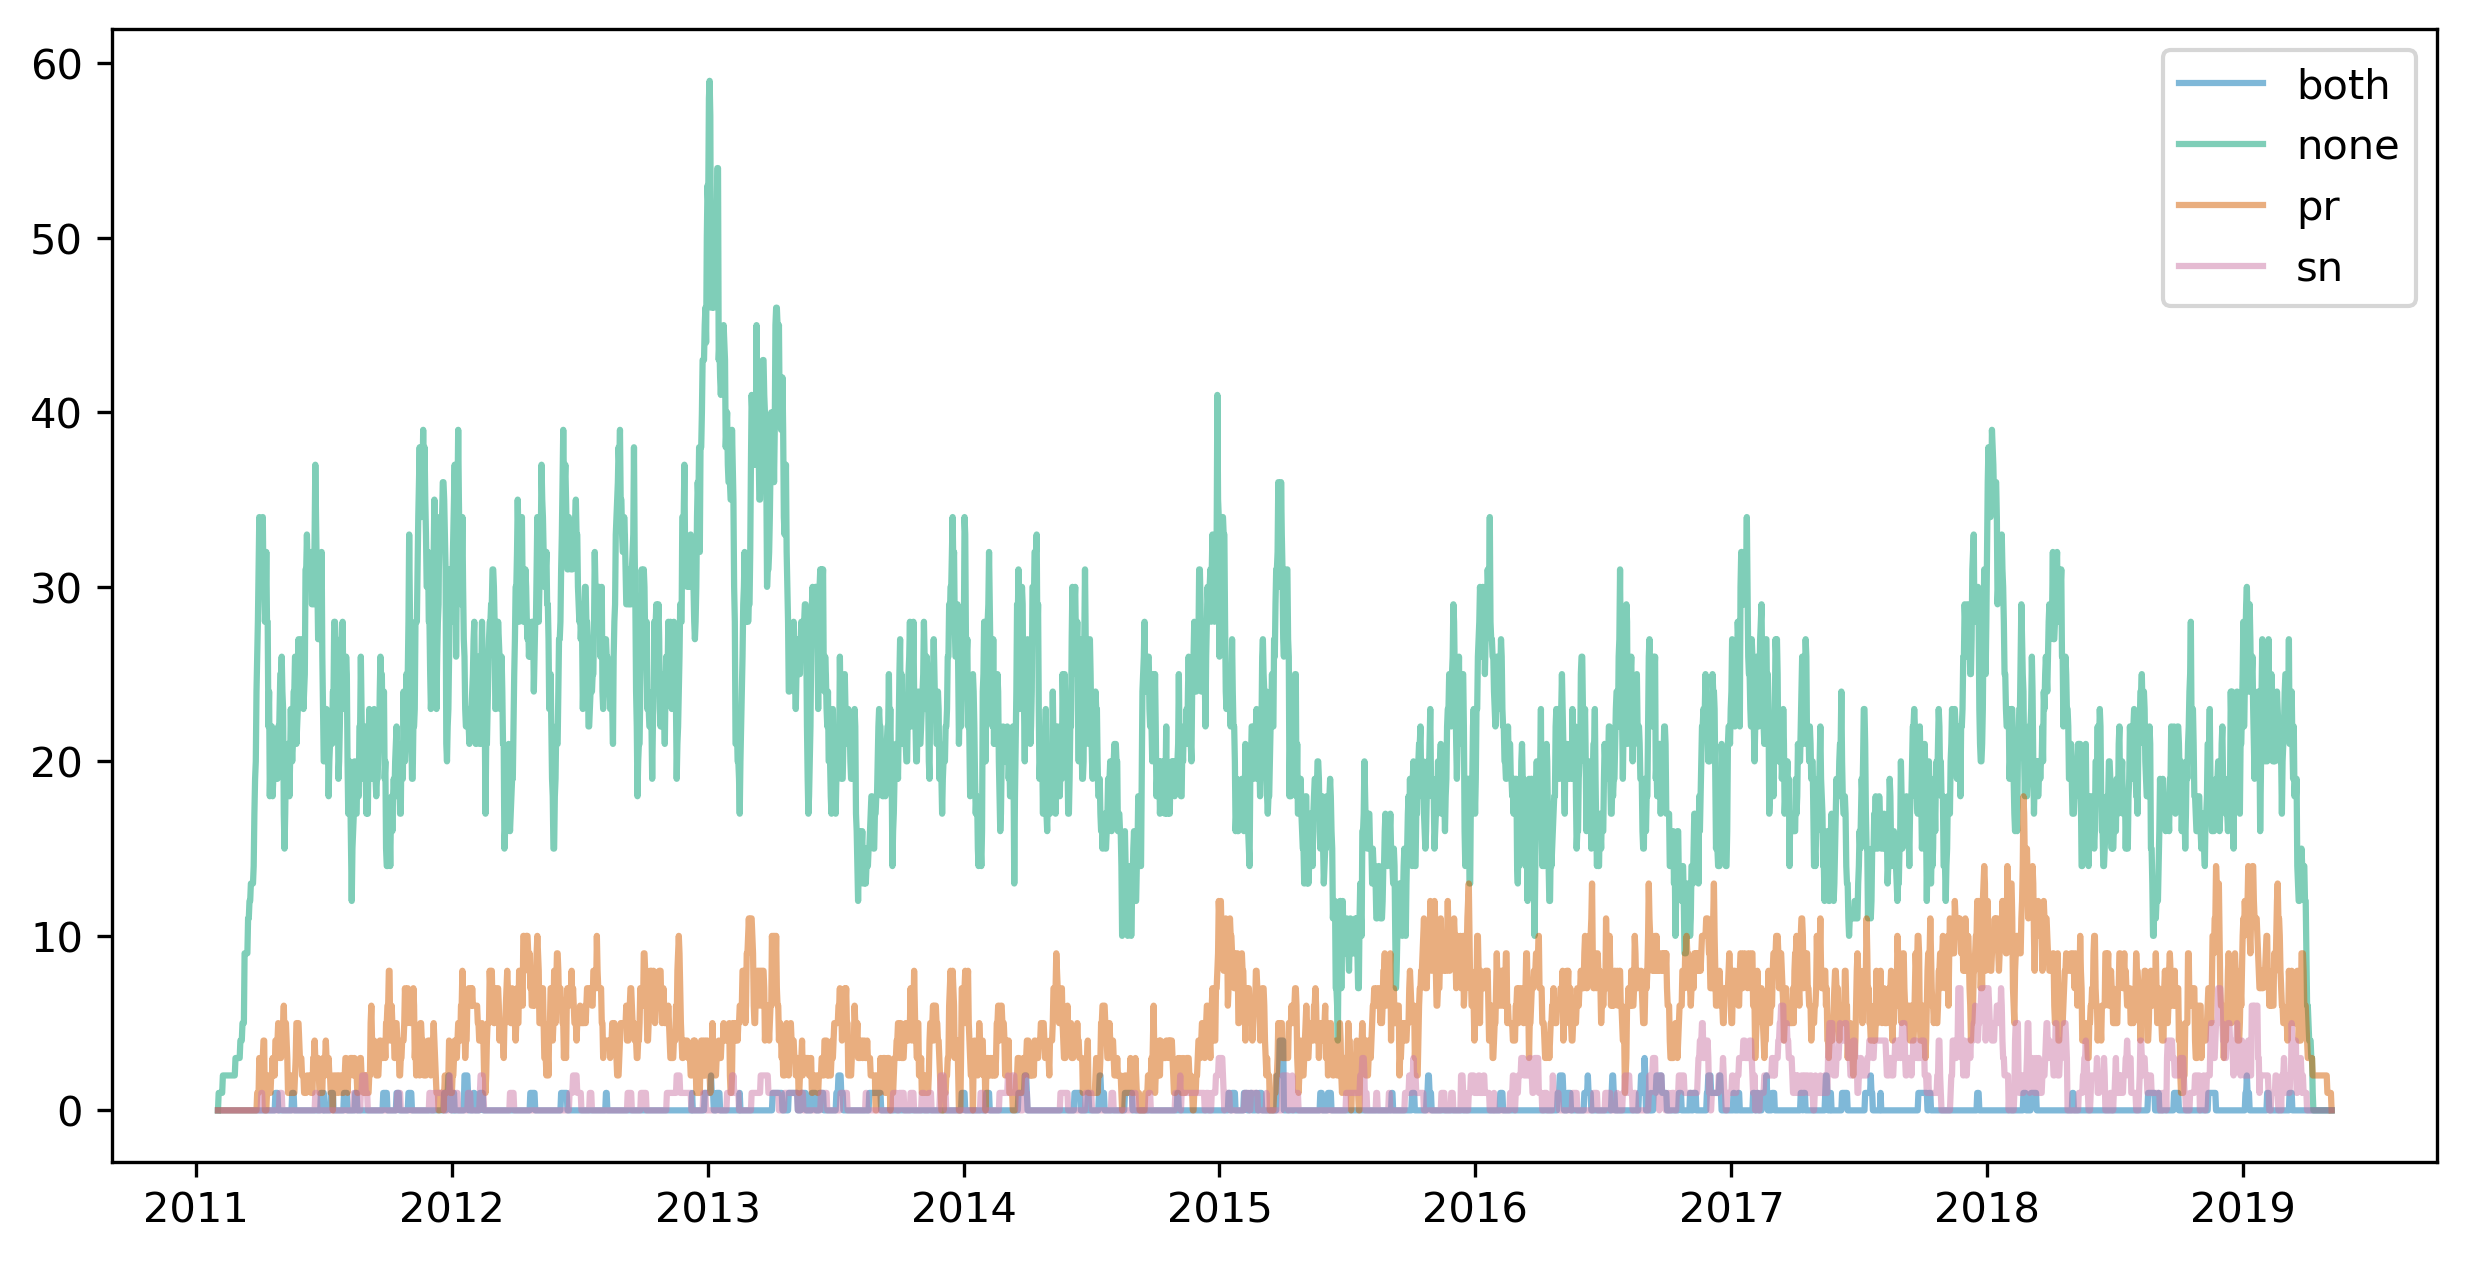

In [33]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

for intervention, data in copd.groupby("intervention"):
    ax.plot(
        system_size["date"], system_size[intervention], alpha=0.5, label=intervention
    )

ax.legend()

system_size.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).iloc[1:, :]


In [34]:
metric_columns = ("los", "n_wards", "n_spells", "spell_cost", "n_icds")
column_dicts = {}
for col in metric_columns:
    groupby = copd.groupby(["patient_id", "intervention"])
    column_dicts[f"mean_{col}"] = groupby[col].mean().to_dict()
    column_dicts[f"variation_{col}"] = (
        groupby[col].var() / groupby[col].mean()
    ).to_dict()

metric_df = pd.DataFrame(column_dicts)


In [35]:
patient_copd = pd.DataFrame(copd[["patient_id", "intervention"]].copy())
patient_copd = patient_copd.set_index(["patient_id", "intervention"]).drop_duplicates()
patient_copd = (
    pd.concat((patient_copd, metric_df), sort=False)
    .dropna(axis=0, how="all")
    .reset_index()
)


(9.5, -0.5)

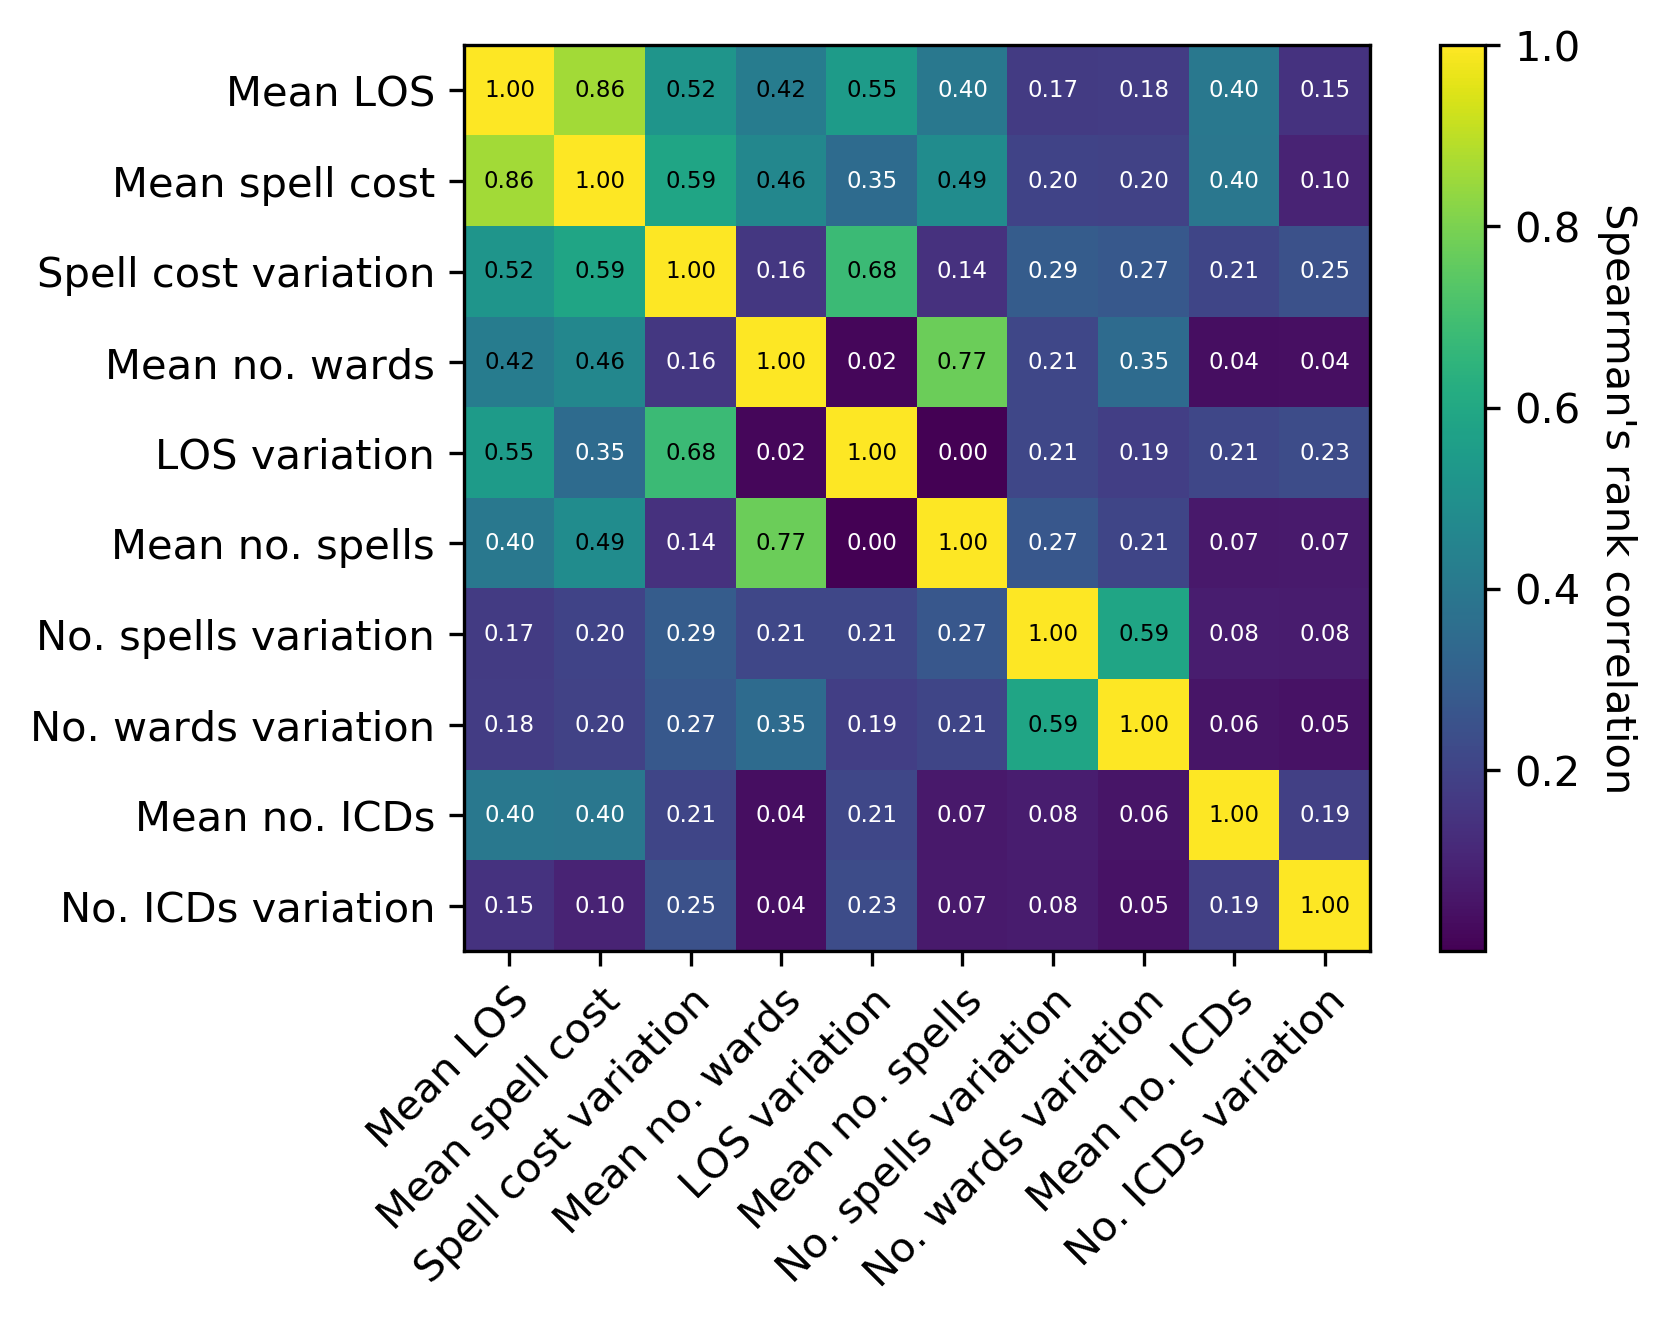

In [36]:
fig, ax = plt.subplots(dpi=300)

correlation = patient_copd.set_index("patient_id").corr(method="spearman")
order = sorted(correlation.columns, key=lambda col: -abs(correlation[col]).sum())
correlation = correlation[order].reindex(order)
data = correlation.values

im = ax.imshow(data)

cbar = ax.figure.colorbar(im)
cbar.ax.set_ylabel("Spearman's rank correlation", rotation=-90, va="bottom")

labels = []
for label in correlation.columns:
    label_parts = label.split("_")
    while "n" in label_parts:
        idx = label_parts.index("n")
        label_parts[idx] = "no."
    if "variation" in label_parts:
        label_parts = label_parts[1:] + [label_parts[0]]
    
    label = " ".join(label_parts)
    label = label.capitalize().replace("los", "LOS").replace("Los", "LOS").replace("icd", "ICD")
    
    labels.append(label)

ax.set(
    xticks=range(correlation.columns.nunique()),
    xticklabels=labels,
    yticks=range(correlation.index.nunique()),
    yticklabels=labels,
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

threshold = im.norm(data.max()) / 2.4
textcolours = ["k", "w"]
textkw = {
    "fontsize": 5.5,
    "horizontalalignment": "center",
    "verticalalignment": "center",
}

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        textkw.update(color=textcolours[int(im.norm(data[i, j]) < threshold)])
        ax.text(j, i, f"{data[i, j]:.2f}", **textkw)

ax.set_ylim(len(correlation) - 0.5, -0.5)


### Patient-level intervention cost distribution


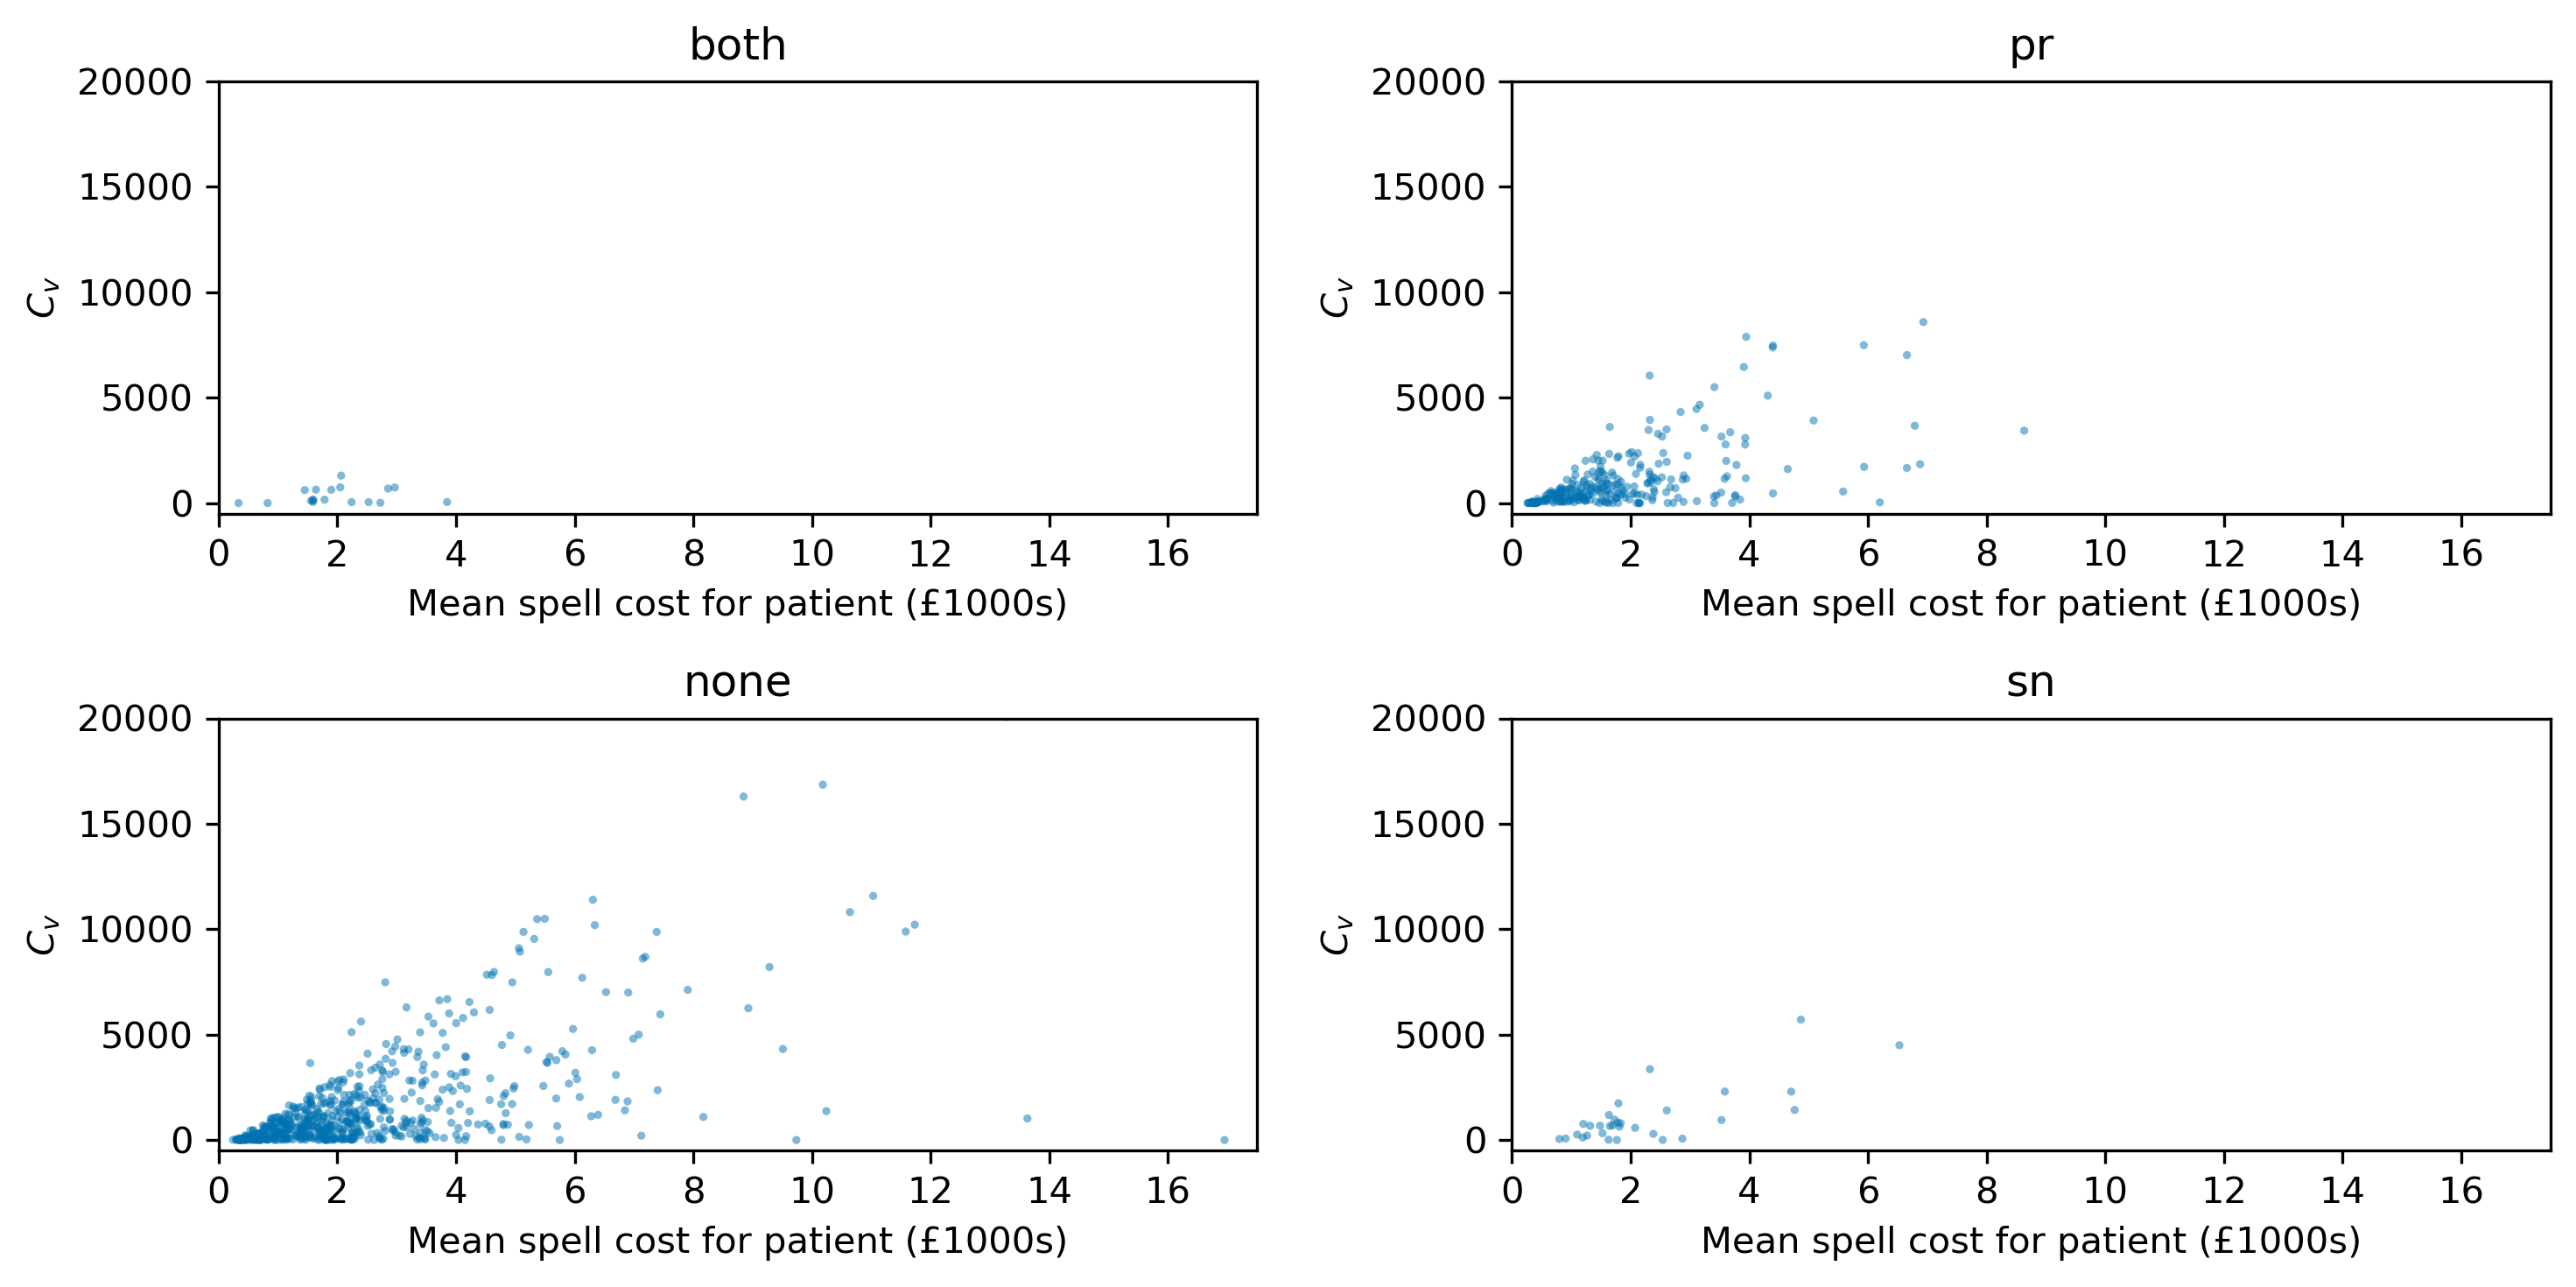

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), dpi=300)

for i, (intervention, data) in enumerate(patient_copd.groupby("intervention")):
    ax = axes[i % 2, int(i >= 2)]
    ax.scatter(
        data["mean_spell_cost"], data["variation_spell_cost"], s=5, alpha=0.5, ec="None"
    )

    ax.set_xlim(0, 17500)
    ax.set_ylim(-500, 20000)
    ax.set_title(intervention)
    ax.set_xlabel("Mean spell cost for patient (£1000s)")
    ax.set_ylabel("$C_v$")
    ax.set_xticklabels(range(0, 18, 2))

plt.tight_layout()


## Metrics of performance (LOS, ICDs, etc.)


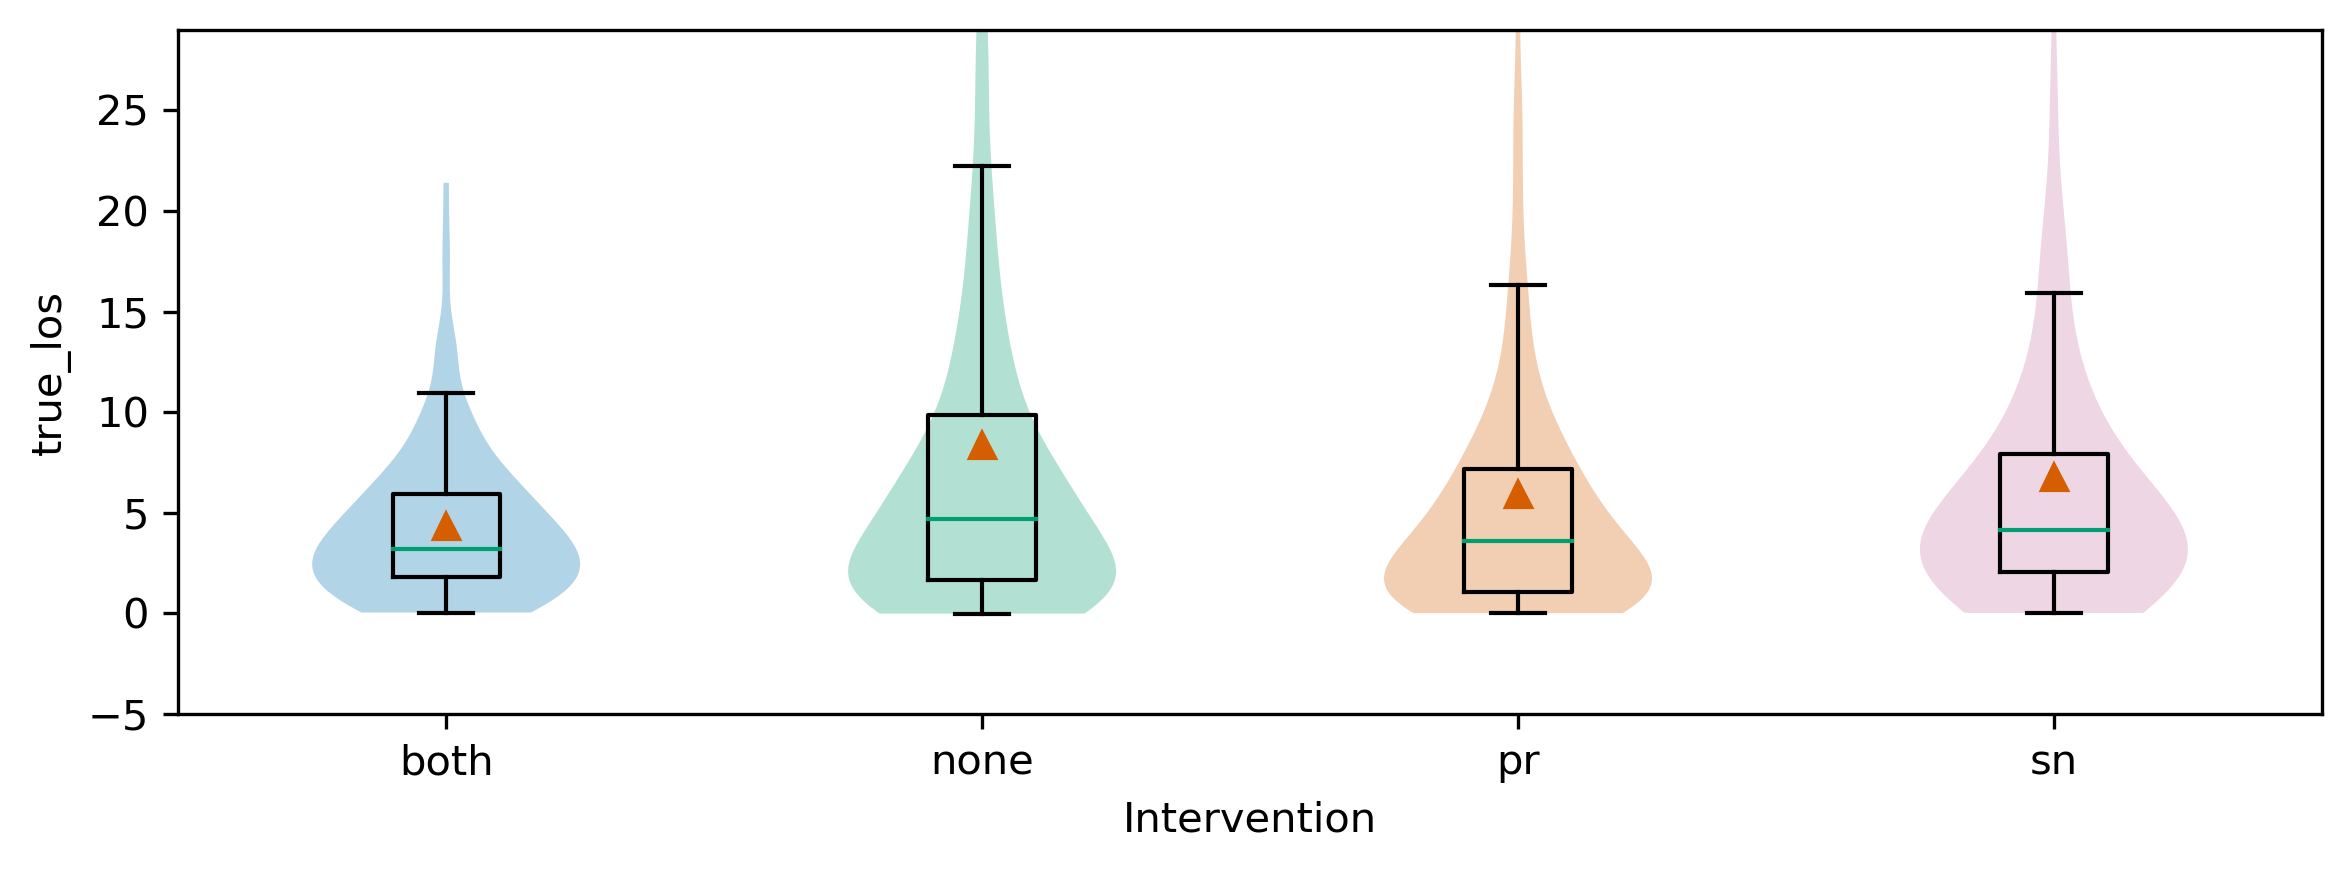

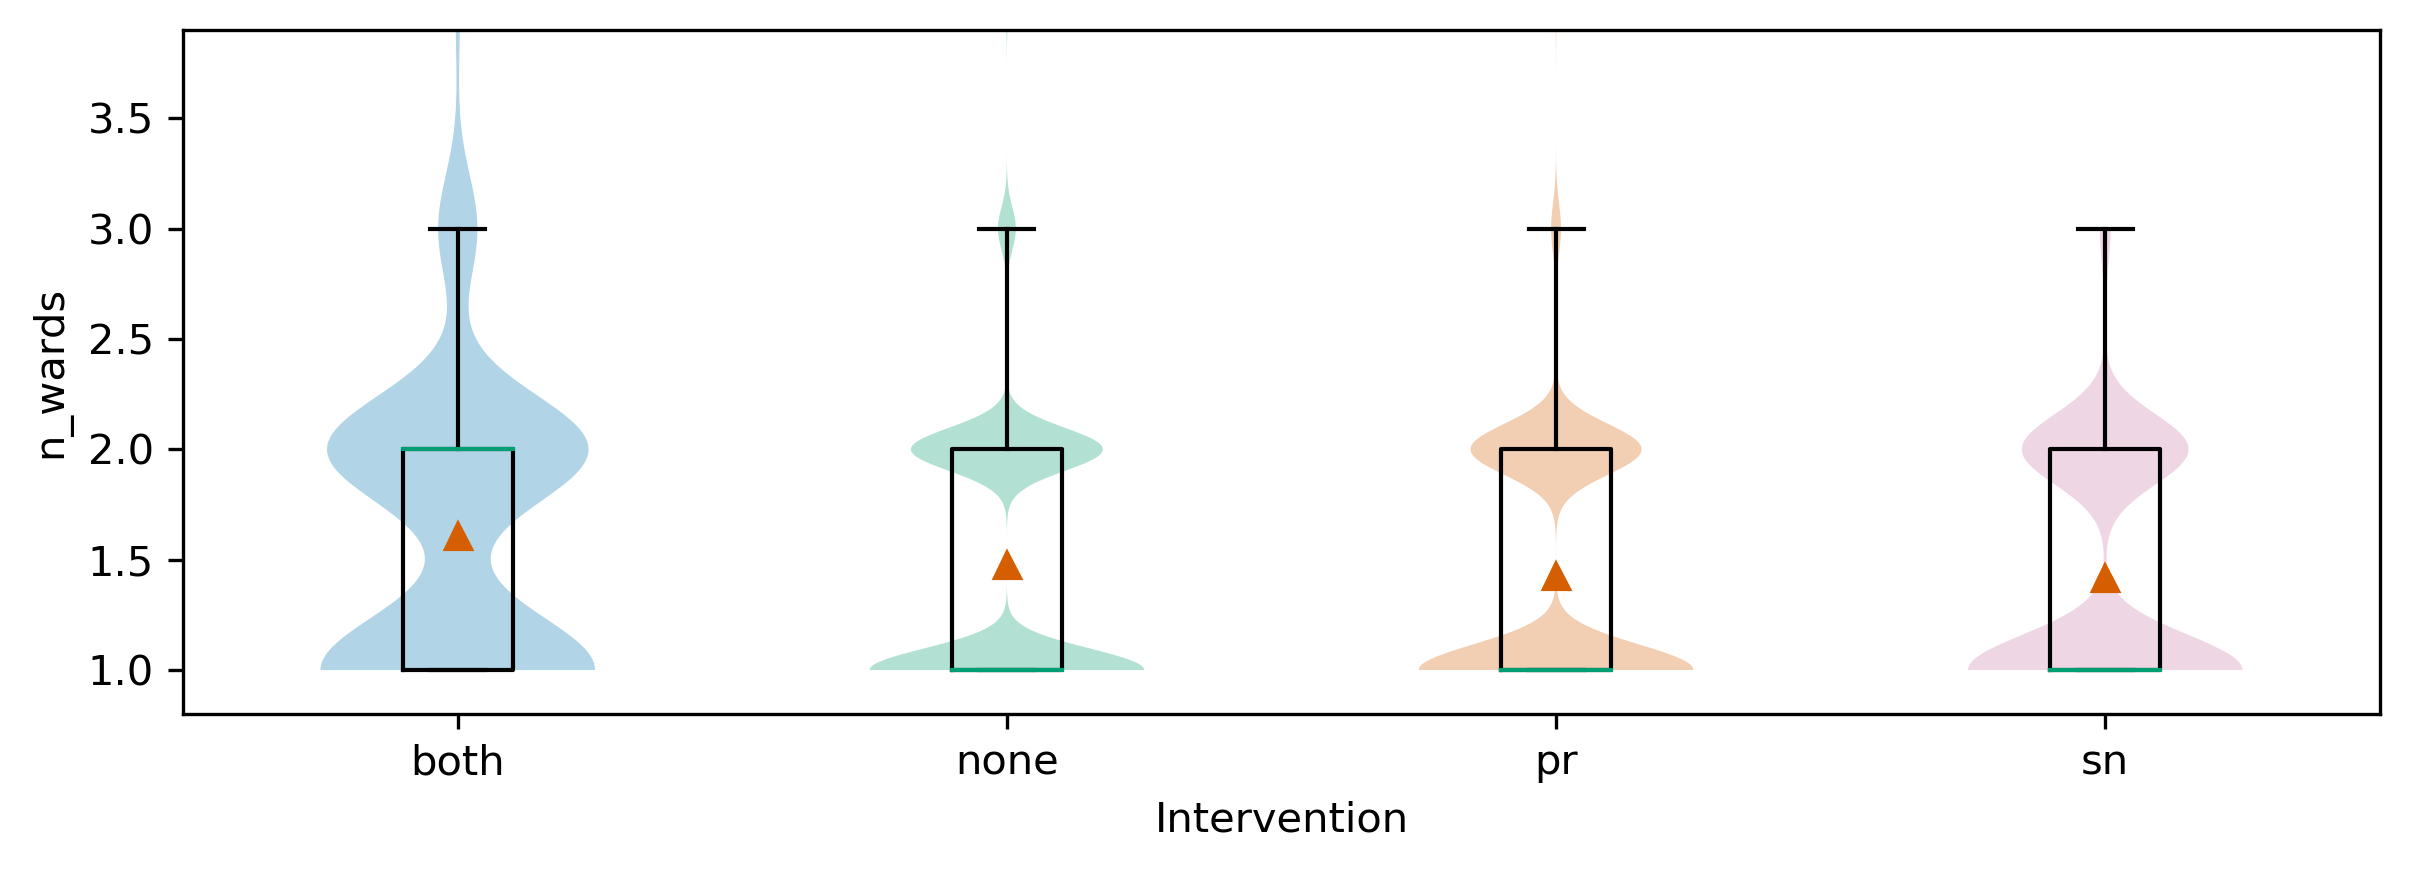

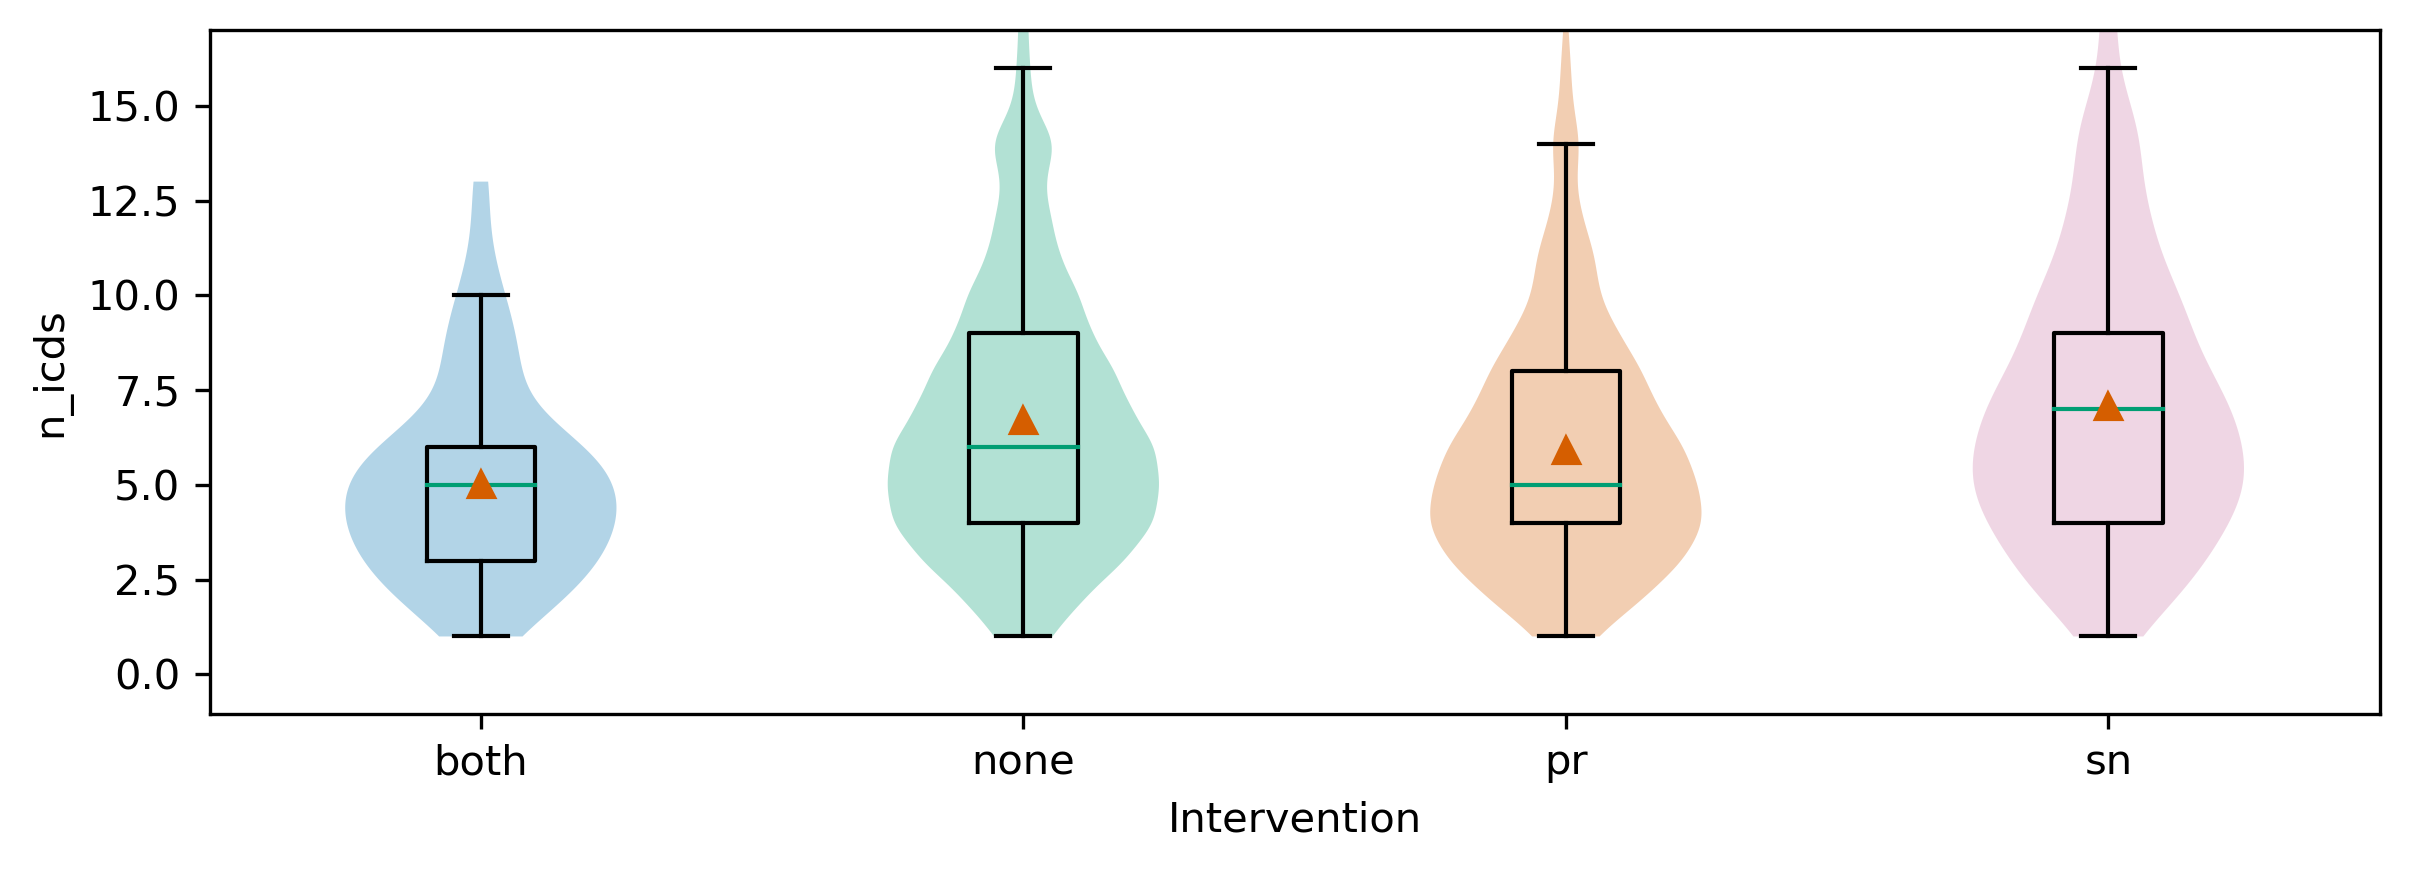

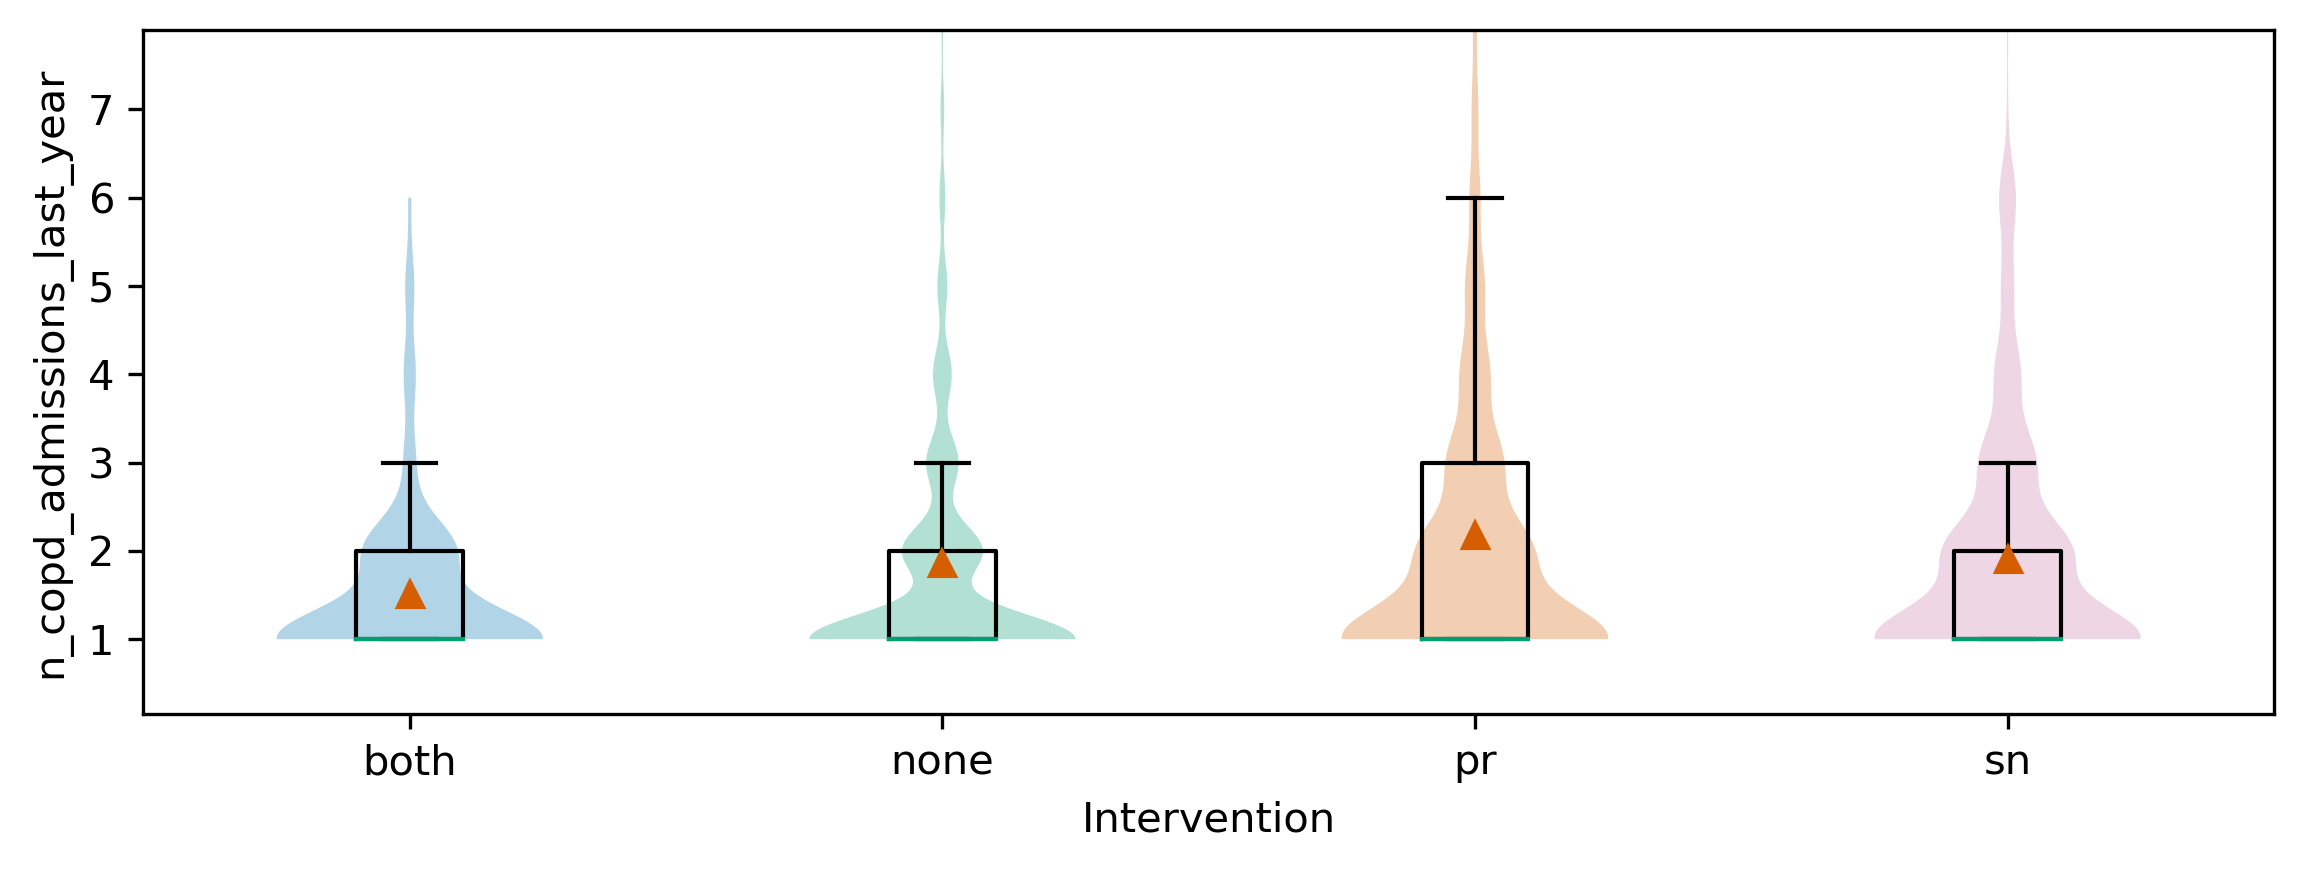

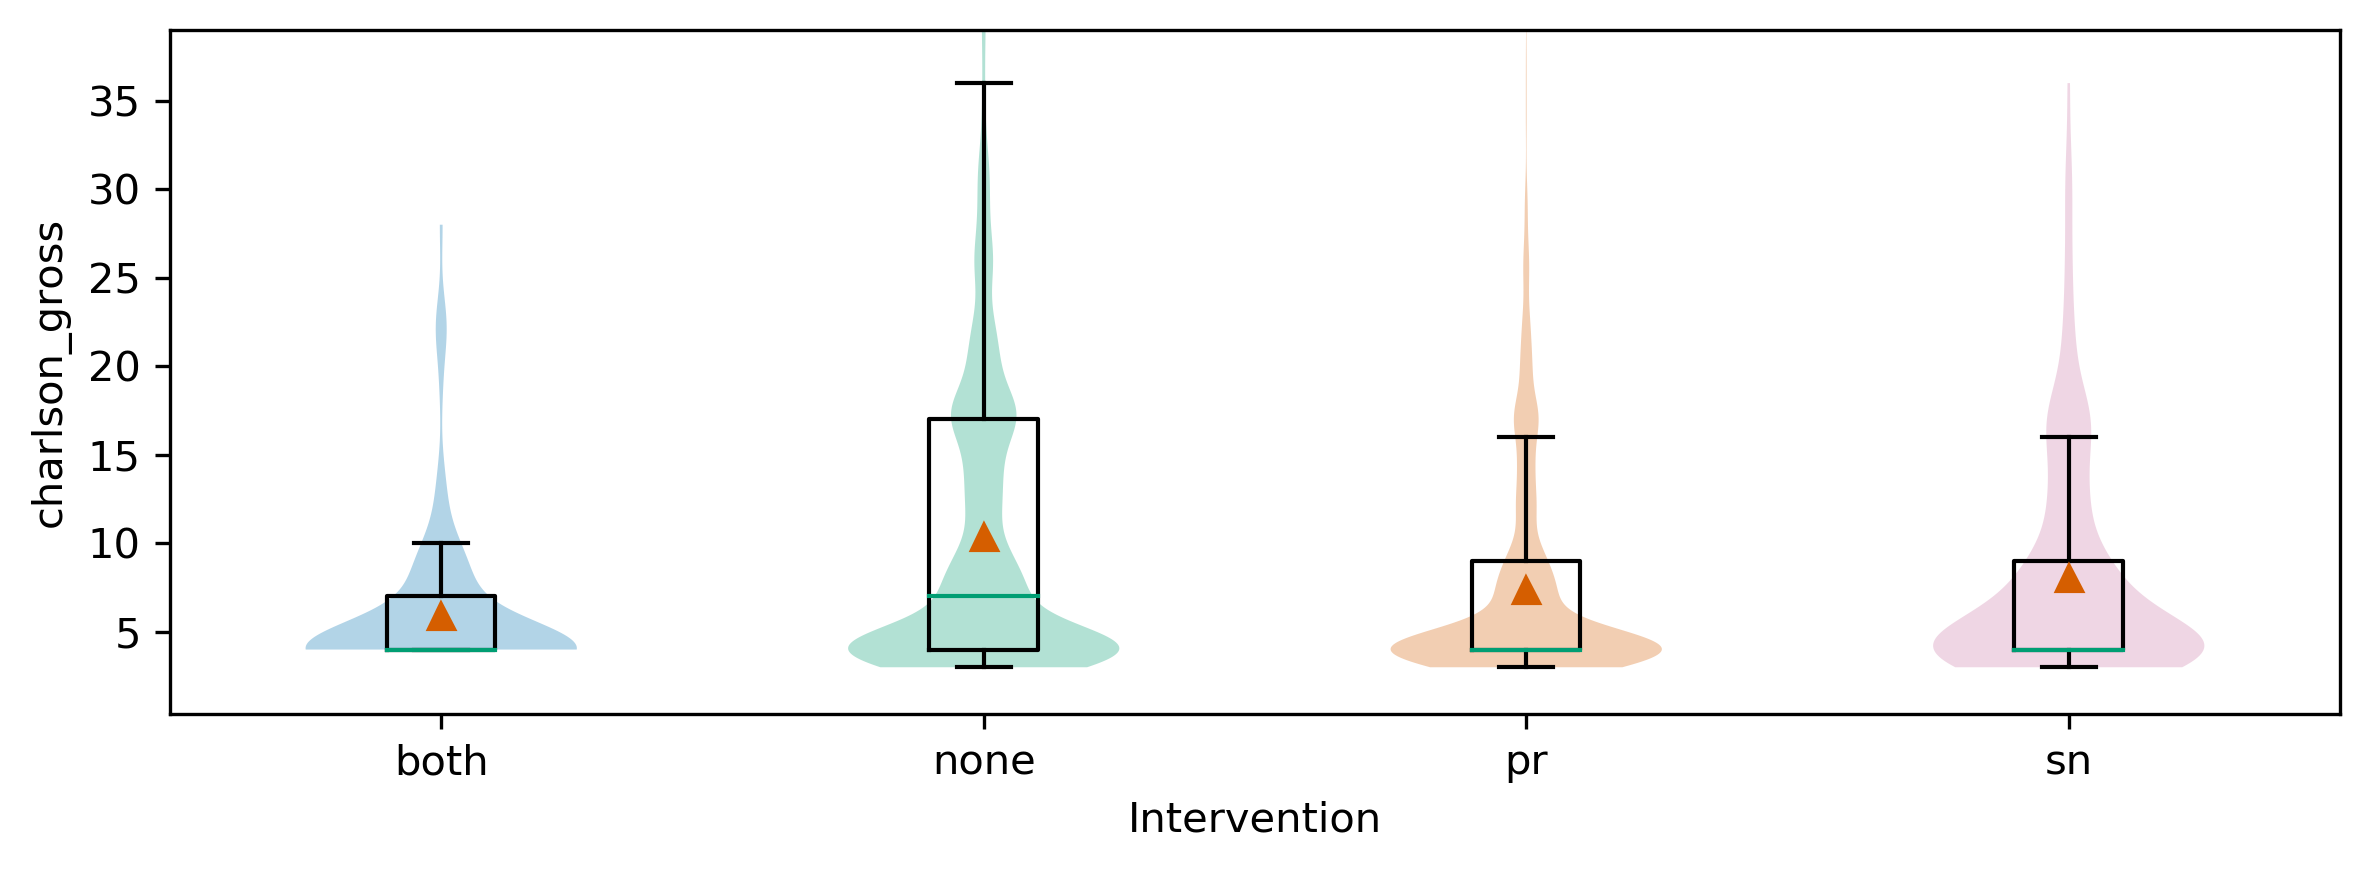

In [51]:
for column, yupper in zip(
    ("true_los", "n_wards", "n_icds", "n_copd_admissions_last_year", "charlson_gross"),
    (29, 3.9, 17, 7.9, 39),
):

    fig, ax = plt.subplots(figsize=(8, 3), dpi=300)

    xticklabels = []
    for pos, (group, values) in enumerate(copd.groupby("intervention")[column]):
        data = values.clip(upper=cutoff)
        ax.violinplot(data, (pos,), showextrema=False, points=1000)
        ax.boxplot(data, positions=(pos,), sym="", showmeans=True, widths=0.2)
        xticklabels.append(group)

    ax.set_xlabel("Intervention")
    ax.set_ylabel(column)
    ax.set_xticklabels(xticklabels)
    plt.tight_layout()
    lower, _ = ax.get_ylim()
    ax.set_ylim(lower, yupper)


In [39]:
def get_statistical_results(test_function, column):

    results = pd.DataFrame(
        columns=intervention_categories, index=intervention_categories
    )

    for ((group1, values1), (group2, values2)) in it.product(
        copd.groupby("intervention")[column], repeat=2
    ):
        if group1 != group2:
            results.loc[group1, group2] = test_function(values1, values2).pvalue

    return results


### Length of stay


In [40]:
stats.kruskal(
    *[copd[copd["intervention"] == val]["true_los"] for val in intervention_categories]
)


KruskalResult(statistic=97.85035356450136, pvalue=4.5046307295141266e-21)

In [41]:
mann_whitney_los_results = get_statistical_results(stats.mannwhitneyu, "true_los")

mann_whitney_los_results


,none,pr,sn,both
none,NaN,1.00704e-21,0.182833,0.000679089
pr,1.00704e-21,NaN,7.75783e-05,0.309616
sn,0.182833,7.75783e-05,NaN,0.00523222
both,0.000679089,0.309616,0.00523222,NaN


### Number of wards


In [42]:
stats.kruskal(
    *[copd[copd["intervention"] == val]["n_wards"] for val in intervention_categories]
)


KruskalResult(statistic=22.36882060231152, pvalue=5.466235811493027e-05)

In [43]:
mann_whitney_n_wards_results = get_statistical_results(stats.mannwhitneyu, "n_wards")

mann_whitney_n_wards_results


,none,pr,sn,both
none,NaN,0.000150168,0.026363,0.00938945
pr,0.000150168,NaN,0.407303,0.000513531
sn,0.026363,0.407303,NaN,0.00116064
both,0.00938945,0.000513531,0.00116064,NaN


### Number of ICDs


In [44]:
stats.kruskal(
    *[copd[copd["intervention"] == val]["n_icds"] for val in intervention_categories]
)


KruskalResult(statistic=130.1810850348262, pvalue=4.943664959450171e-28)

In [45]:
mann_whitney_n_icds_results = get_statistical_results(stats.mannwhitneyu, "n_icds")

mann_whitney_n_icds_results


,none,pr,sn,both
none,NaN,2.3294e-22,0.0133509,9.39553e-09
pr,2.3294e-22,NaN,1.14864e-10,0.000992686
sn,0.0133509,1.14864e-10,NaN,1.31732e-09
both,9.39553e-09,0.000992686,1.31732e-09,NaN


### Number of COPD-related admissions in the last year


In [46]:
stats.kruskal(
    *[
        copd[copd["intervention"] == val]["n_copd_admissions_last_year"]
        for val in intervention_categories
    ]
)


KruskalResult(statistic=113.82317091755895, pvalue=1.6498115707169961e-24)

In [47]:
mann_whitney_n_icds_results = get_statistical_results(
    stats.mannwhitneyu, "n_copd_admissions_last_year"
)

mann_whitney_n_icds_results


,none,pr,sn,both
none,NaN,3.32268e-24,0.00010258,0.0424364
pr,3.32268e-24,NaN,0.114614,1.38754e-05
sn,0.00010258,0.114614,NaN,0.000328338
both,0.0424364,1.38754e-05,0.000328338,NaN


### Charlson comorbidity index


In [48]:
stats.kruskal(
    *[
        copd[copd["intervention"] == val]["charlson_gross"]
        for val in intervention_categories
    ]
)


KruskalResult(statistic=310.4405723165059, pvalue=5.4702579426741774e-67)

In [49]:
mann_whitney_charlson_gross_results = get_statistical_results(
    stats.mannwhitneyu, "charlson_gross"
)

mann_whitney_charlson_gross_results


,none,pr,sn,both
none,NaN,5.31138e-60,3.66945e-08,2.73958e-11
pr,5.31138e-60,NaN,0.00636371,0.003309
sn,3.66945e-08,0.00636371,NaN,0.000116671
both,2.73958e-11,0.003309,0.000116671,NaN
